In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates
import os
%config InlineBackend.figure_format = 'retina'
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# fipstate
fips_to_state = {
    1: "Alabama",
    2: "Alaska",
    4: "Arizona",
    5: "Arkansas",
    6: "California",
    8: "Colorado",
    9: "Connecticut",
    10: "Delaware",
    11: "District of Columbia",
    12: "Florida",
    13: "Georgia",
    15: "Hawaii",
    16: "Idaho",
    17: "Illinois",
    18: "Indiana",
    19: "Iowa",
    20: "Kansas",
    21: "Kentucky",
    22: "Louisiana",
    23: "Maine",
    24: "Maryland",
    25: "Massachusetts",
    26: "Michigan",
    27: "Minnesota",
    28: "Mississippi",
    29: "Missouri",
    30: "Montana",
    31: "Nebraska",
    32: "Nevada",
    33: "New Hampshire",
    34: "New Jersey",
    35: "New Mexico",
    36: "New York",
    37: "North Carolina",
    38: "North Dakota",
    39: "Ohio",
    40: "Oklahoma",
    41: "Oregon",
    42: "Pennsylvania",
    44: "Rhode Island",
    45: "South Carolina",
    46: "South Dakota",
    47: "Tennessee",
    48: "Texas",
    49: "Utah",
    50: "Vermont",
    51: "Virginia",
    53: "Washington",
    54: "West Virginia",
    55: "Wisconsin",
    56: "Wyoming",
}

In [4]:
# Medicaid_eligibility by Decemger 2024
# 32 states Medicaid expanded under the ACA
# 19 states didn't expand mediciad expansion
medicaid_eligibility = {
    "Alabama": 0,  # Control
    "Alaska": 1,  # Expanded later November 1, 2015
    "Arizona": 1,
    "Arkansas": 1,
    "California": 1,
    "Colorado": 1,
    "Connecticut": 1,
    "Delaware": 1,
    "District of Columbia": 1,
    "Florida": 0,
    "Georgia": 0,
    "Hawaii": 1,
    "Idaho": 0,
    "Illinois": 1,
    "Indiana": 1, # Expanded later February 1, 2015
    "Iowa": 1,
    "Kansas": 0,
    "Kentucky": 1,
    "Louisiana": 1, # Expanded later July 1, 2016
    "Maine": 0,
    "Maryland": 1,
    "Massachusetts": 1,
    "Michigan": 1, # Expanded later April 1,2014
    "Minnesota": 1,
    "Mississippi": 0,
    "Missouri": 0,
    "Montana": 1, # Expanded later January 1, 2016
    "Nebraska": 0,
    "Nevada": 1,
    "New Hampshire": 1, # Expanded later August 15, 2014
    "New Jersey": 1,
    "New Mexico": 1,
    "New York": 1,
    "North Carolina": 0,
    "North Dakota": 1,
    "Ohio": 1,
    "Oklahoma": 0,
    "Oregon": 1,
    "Pennsylvania": 1, # Expanded later January 1, 2015
    "Rhode Island": 1,
    "South Carolina": 0,
    "South Dakota": 0,
    "Tennessee": 0,
    "Texas": 0,
    "Utah": 0,
    "Vermont": 1,
    "Virginia": 0,
    "Washington": 1,
    "West Virginia": 1,
    "Wisconsin": 0,
    "Wyoming": 0,
}

In [5]:
# As a dataframe
brfss_clean = {}
brfss_clean_analysis = {}

age_replace = {'18-24':21,
               '25-29':27,
               '30-34':32,
               '35-39':37,
               '40-44':42,
               '45-49':47,
               '50-54':52,
               '55-59':57,
               '60-64':62
               }

for i in range(2004, 2019):
    brfss_clean[i] = pd.read_csv(f'/content/drive/MyDrive/econ191/clean/cdc/clean2/brfss_{i}_clean.csv')
    brfss_clean[i].drop(columns=['Unnamed: 0'], inplace=True)
    #brfss_clean[i]['age'] =  brfss_clean[i]['age'][brfss_clean[i]['age'] != '18-24'] # Drop 18-24
    brfss_clean[i]['age'] =  brfss_clean[i]['age'].map(age_replace)
    brfss_clean[i] = brfss_clean[i][['year','state','income','children','adult','age','health_access','race','household_size','general_health','bmi','mental_health','physical_health','fpl_threshold','income_percent_fpl']]
    brfss_clean_analysis[i] = brfss_clean[i][brfss_clean[i]['income_percent_fpl'] < 138] # Only for those groups with below 138 fpl
    brfss_clean_analysis[i] = brfss_clean_analysis[i][brfss_clean_analysis[i]['state'] != 66]
    brfss_clean_analysis[i]['state'] = brfss_clean_analysis[i]['state'].map(fips_to_state)
    brfss_clean_analysis[i]['treatment'] = brfss_clean_analysis[i]['state'].map(medicaid_eligibility)
    # Imputed values with mean of BMI(Since missing values are huge)
    mean_bmi = np.nanmean(brfss_clean_analysis[i]['bmi'])
    brfss_clean_analysis[i]['bmi'].fillna(mean_bmi, inplace=True)
    if i<2014:
      # brfss_clean_analysis[i]['treatment'] = 0
      brfss_clean_analysis[i]['pre_post'] = 0
    else:
       brfss_clean_analysis[i]['pre_post'] = 1
    brfss_clean_analysis[i]['did'] = brfss_clean_analysis[i]['treatment'] * brfss_clean_analysis[i]['pre_post']
    # 1) Only 'Excellent' indicates 1, others are 0
    brfss_clean_analysis[i]['general_health_binary(1)'] = brfss_clean_analysis[i]['general_health'].map({'Excellent': 1}).fillna(0).astype(int)
    # 2) 'Excellent', 'Very good', others are 0
    brfss_clean_analysis[i]['general_health_binary(2)'] = brfss_clean_analysis[i]['general_health'].map({'Excellent': 1, 'Very good': 1}).fillna(0).astype(int)
    # 3) 'Excellent', 'Very good', 'Good' are 1, others are 0
    brfss_clean_analysis[i]['general_health_binary(3)'] = brfss_clean_analysis[i]['general_health'].map({'Excellent': 1, 'Very good': 1, 'Good': 1}).fillna(0).astype(int)
    # 4) 'Excellent', 'Very good', 'Good', 'Fair' are 1, others are 0
    brfss_clean_analysis[i]['general_health_binary(4)'] = brfss_clean_analysis[i]['general_health'].map({'Excellent': 1, 'Very good': 1, 'Good': 1, 'Fair': 1}).fillna(0).astype(int)

    brfss_clean_analysis[i]['mental_health'] = pd.to_numeric(brfss_clean_analysis[i]['mental_health'], errors='coerce')
    brfss_clean_analysis[i]['physical_health'] = pd.to_numeric(brfss_clean_analysis[i]['physical_health'], errors='coerce')
    brfss_clean_analysis[i]['bmi_indicator']  = np.where(brfss_clean_analysis[i]['bmi']>=30,1,0).astype(int)
    brfss_clean_analysis[i] = brfss_clean_analysis[i].groupby(['state']).agg(
    year =('year', 'first'),
    age=('age', 'median'),
    race=('race', lambda x: x.mode()[0] if not x.mode().empty else None),  # Mode (most frequent)
    records=('state', 'size'),
    treatment=('treatment', 'first'),
    pre_post=('pre_post', 'first'),
    did=('did', 'first'),
    avg_child=('children', 'mean'),
    avg_adult=('adult', 'mean'),
    avg_household_size=('household_size', 'mean'),
    avg_health_access=('health_access', 'mean'),
    avg_mental_health=('mental_health', 'mean'),
    avg_bmi=('bmi', 'mean'),
    bmi_indicator=('bmi_indicator', 'mean'),
    avg_physical_health=('physical_health', 'mean'),
    avg_fpl_threshold=('fpl_threshold', 'mean'),
    avg_income_percent_fpl=('income_percent_fpl', 'mean'),
    gen_health_binary1=('general_health_binary(1)', 'mean'),
    gen_health_binary2=('general_health_binary(2)', 'mean'),
    gen_health_binary3=('general_health_binary(3)', 'mean'),
    gen_health_binary4=('general_health_binary(4)', 'mean')
)


In [6]:
'''
# Define the age bins and their corresponding labels
age_bins = [0, 24, 29, 34, 39.5, 44, 49, 54, 59, 64, float('inf')]
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65+']

# Loop through each year from 2004 to 2018 (inclusive)
for i in range(2004, 2019):
    if 'age' in brfss_clean[i].columns:
        # Use pd.cut() to categorize ages into bins
         brfss_clean_analysis[i]['age'] = brfss_clean_analysis[i]['age'].round()
         brfss_clean_analysis[i]['age_group'] = pd.cut(brfss_clean_analysis[i]['age'], bins=age_bins, labels=age_labels, right=True)
'''

"\n# Define the age bins and their corresponding labels\nage_bins = [0, 24, 29, 34, 39.5, 44, 49, 54, 59, 64, float('inf')]\nage_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65+']\n\n# Loop through each year from 2004 to 2018 (inclusive)\nfor i in range(2004, 2019):\n    if 'age' in brfss_clean[i].columns:\n        # Use pd.cut() to categorize ages into bins\n         brfss_clean_analysis[i]['age'] = brfss_clean_analysis[i]['age'].round()\n         brfss_clean_analysis[i]['age_group'] = pd.cut(brfss_clean_analysis[i]['age'], bins=age_bins, labels=age_labels, right=True)\n"

In [7]:
merged_brfss = pd.concat(brfss_clean_analysis.values())
merged_brfss = merged_brfss.reset_index()
merged_brfss.rename(columns={'index': 'state'}, inplace=True)
merged_brfss.to_csv('/content/drive/MyDrive/econ191/clean/cdc/clean2/merged_brfss.csv')

In [8]:
# Enrollment rates data
# Rename the column
enrollment_rates = pd.read_csv('/content/drive/MyDrive/econ191/raw/educ/enrollment_rates_fall.csv')
enrollment_rates.rename(columns={'State or Region': 'state'}, inplace=True)
for year in range(2003, 2019):
    enrollment_rates.rename(columns={'Fall_' + str(year): year}, inplace=True)
excluded_states = ['United States', 'Midwest', 'Northeast', 'South', 'West']
enrollment_rates = enrollment_rates[~enrollment_rates['state'].isin(excluded_states)]
enrollment_rates = enrollment_rates.drop(columns=['sector_sort','Unnamed: 19','Unnamed: 20'])

In [9]:
enrollment_rates_overall = enrollment_rates[enrollment_rates['Institution Sector'] == 'Overall']
enrollment_rates_overall.drop(columns=['Institution Sector'], inplace=True)
enrollment_rates_analysis = enrollment_rates_overall.melt(id_vars=['state'], value_vars=[year for year in range(2003, 2019)], var_name='year', value_name='enrollment_rate')
enrollment_rates_analysis = enrollment_rates_analysis[enrollment_rates_analysis['year']!=2003]

In [10]:
enrollment_rates_analysis = enrollment_rates_analysis[enrollment_rates_analysis['year']!=2003]

In [11]:
enrollment_rates_analysis['state'] = enrollment_rates_analysis['state'].str.replace('_', ' ')

In [12]:
nof_enrollment = pd.read_csv('/content/drive/MyDrive/econ191/raw/educ/nof_enrollments_fall.csv')
nof_enrollment.rename(columns={'State or Region': 'state'}, inplace=True)
for year in range(2003, 2019):
    nof_enrollment.rename(columns={'Fall_' + str(year) + '_IPEDS_Universe': year}, inplace=True)
    nof_enrollment.drop(columns={'Fall_' + str(year) + '_Active'})
excluded_states = ['United States', 'Midwest', 'Northeast', 'South', 'West']
nof_enrollment = nof_enrollment[~nof_enrollment['state'].isin(excluded_states)]

nof_enrollment_overall = nof_enrollment[nof_enrollment['Institution Sector'] == 'Overall']
nof_enrollment_overall.drop(columns=['Institution Sector'], inplace=True)
nof_enrollment_analysis = nof_enrollment_overall.melt(id_vars=['state'], value_vars=[year for year in range(2003, 2019)], var_name='year', value_name='nof_enrollments')
nof_enrollment_analysis = nof_enrollment_analysis[nof_enrollment_analysis['year']!=2003]
nof_enrollment_analysis['state'] = nof_enrollment_analysis['state'].str.replace('_', ' ')

In [13]:
# Merge two dataframes
merged_enrollment_rates = pd.merge(merged_brfss, enrollment_rates_analysis, on=['state', 'year'], how='left')
merged_total = pd.merge(merged_enrollment_rates, nof_enrollment_analysis, on=['state', 'year'], how='left')

In [14]:
merged_total.head()

,state,year,age,race,records,treatment,pre_post,did,avg_child,avg_adult,...,bmi_indicator,avg_physical_health,avg_fpl_threshold,avg_income_percent_fpl,gen_health_binary1,gen_health_binary2,gen_health_binary3,gen_health_binary4,enrollment_rate,nof_enrollments
0,Alabama,2004.0,37.0,white,127,0,0,0,2.110236,1.748031,...,0.314961,12.952756,21865.118110,79.864644,0.031496,0.125984,0.456693,0.811024,76.4%,"255,163"
1,Alaska,2004.0,37.0,white,70,1,0,0,2.157143,1.871429,...,0.271429,10.471429,22433.142857,89.313201,0.071429,0.271429,0.657143,0.857143,97.5%,"30,869"
2,Arizona,2004.0,37.0,white,153,1,0,0,2.379085,1.980392,...,0.248366,12.758170,23509.084967,76.801013,0.039216,0.183007,0.503268,0.856209,63.5%,"584,030"
3,Arkansas,2004.0,37.0,white,146,1,0,0,1.952055,1.842466,...,0.212329,11.952055,21656.027397,74.618531,0.041096,0.219178,0.561644,0.856164,88.3%,"137,857"
4,California,2004.0,37.0,hispanic,188,1,0,0,2.271277,2.212766,...,0.138298,10.553191,23917.659574,71.192984,0.063830,0.196809,0.510638,0.888298,92.1%,"2,325,971"


In [15]:
print(len(merged_total))
print(merged_total['records'].sum())

761
91429


In [16]:
print(merged_total[merged_total['treatment'] == 1]['records'].sum())
print(merged_total[merged_total['treatment'] == 0]['records'].sum())
print(merged_total[merged_total['treatment'] == 0]['records'].sum())

53041
38388
38388


In [17]:
merged_total['avg_bmi'].isna().sum()

0

In [18]:
merged_total['enrollment_rate'] = merged_total['enrollment_rate'].replace('%', '', regex=True).astype(float)
merged_total['enrollment_rate'] = merged_total['enrollment_rate']/100
merged_total['enrollment_rate'] = round(merged_total['enrollment_rate'], 3)

# Converting 'nof_enrollments' to numeric (remove commas if necessary)
merged_total['nof_enrollments'] = merged_total['nof_enrollments'].replace(',', '', regex=True).astype(int)
merged_total['enrollment_rate'] = merged_total['enrollment_rate']
merged_total['nof_enrollments'] = round(merged_total['nof_enrollments'], 3)

In [19]:
merged_total.to_csv('/content/drive/MyDrive/econ191/clean/cdc/clean2/merged_brfss_enrollment.csv')

In [20]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates
import os
%config InlineBackend.figure_format = 'retina'
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
merged_total = pd.read_csv('/content/drive/MyDrive/econ191/clean/cdc/clean2/merged_brfss_enrollment.csv')
merged_total.drop(columns=['Unnamed: 0'], inplace=True)

In [22]:
# Summary Statistics for medicaid
merged_total.columns

Index(['state', 'year', 'age', 'race', 'records', 'treatment', 'pre_post',
       'did', 'avg_child', 'avg_adult', 'avg_household_size',
       'avg_health_access', 'avg_mental_health', 'avg_bmi', 'bmi_indicator',
       'avg_physical_health', 'avg_fpl_threshold', 'avg_income_percent_fpl',
       'gen_health_binary1', 'gen_health_binary2', 'gen_health_binary3',
       'gen_health_binary4', 'enrollment_rate', 'nof_enrollments'],
      dtype='object')

In [23]:
merged_total['race'].value_counts().reset_index(name='count')

,race,count
0,white,609
1,hispanic,61
2,black,58
3,asian/non-hispanic,15
4,non-hispanic/multiracial,12
5,american indian/alaskan native,6


In [24]:
merged_total[['age','race']].value_counts().reset_index(name='count')

,age,race,count
0,42.0,white,298
1,37.0,white,191
2,47.0,white,68
3,42.0,hispanic,33
4,42.0,black,26
5,37.0,hispanic,20
6,47.0,black,18
7,44.5,white,15
8,39.5,white,13
9,32.0,white,12


In [25]:
merged_total[['race']].value_counts().reset_index(name='count')

,race,count
0,white,609
1,hispanic,61
2,black,58
3,asian/non-hispanic,15
4,non-hispanic/multiracial,12
5,american indian/alaskan native,6


In [26]:
# Sum 'records' by 'treatment' and 'pre_post'
summary = merged_total.groupby(['treatment', 'pre_post'])['records'].sum()

# Print the sums for each group
print("Non-expansion (treatment = 0, pre_post = 0):", summary.loc[(0, 0)])
print("Expansion (treatment = 1, pre_post = 0):", summary.loc[(1, 0)])
print("Non-expansion (treatment = 0, pre_post = 1):", summary.loc[(0, 1)])
print("Expansion (treatment = 1, pre_post = 1):", summary.loc[(1, 1)])


Non-expansion (treatment = 0, pre_post = 0): 32921
Expansion (treatment = 1, pre_post = 0): 44847
Non-expansion (treatment = 0, pre_post = 1): 5467
Expansion (treatment = 1, pre_post = 1): 8194


In [27]:
merged_total[merged_total['treatment'] == 1]['records'].sum()

53041

In [28]:
merged_total[['treatment','pre_post']].value_counts().reset_index(name='count')

,treatment,pre_post,count
0,1,0,318
1,0,0,188
2,1,1,160
3,0,1,95


In [29]:
merged_summary = merged_total[(['treatment','pre_post','age','race','avg_child', 'avg_adult', 'avg_household_size','avg_income_percent_fpl','avg_mental_health','avg_bmi','bmi_indicator','avg_physical_health','gen_health_binary2','gen_health_binary3','enrollment_rate','nof_enrollments'])]

In [30]:
merged_summary.columns

Index(['treatment', 'pre_post', 'age', 'race', 'avg_child', 'avg_adult',
       'avg_household_size', 'avg_income_percent_fpl', 'avg_mental_health',
       'avg_bmi', 'bmi_indicator', 'avg_physical_health', 'gen_health_binary2',
       'gen_health_binary3', 'enrollment_rate', 'nof_enrollments'],
      dtype='object')

In [31]:
merged_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,761.0,0.628121,0.483624,0.000000,0.000000,1.000000,1.000000,1.000000e+00
pre_post,761.0,0.335085,0.472331,0.000000,0.000000,0.000000,1.000000,1.000000e+00
age,761.0,41.109724,3.657290,32.000000,37.000000,42.000000,42.000000,5.450000e+01
avg_child,761.0,2.067206,0.220883,1.333333,1.918033,2.047619,2.181034,3.166667e+00
avg_adult,761.0,2.047045,0.217183,1.500000,1.899384,2.005618,2.148607,3.142857e+00
avg_household_size,761.0,5.114251,0.335975,4.428571,4.879518,5.063020,5.263959,6.645161e+00
avg_income_percent_fpl,761.0,74.365160,7.419390,26.148948,70.010204,74.604688,79.340366,9.614857e+01
avg_mental_health,761.0,14.560665,2.013377,7.636364,13.235294,14.503846,15.854839,2.583333e+01
avg_bmi,761.0,27.953673,0.857722,22.365372,27.403609,27.948936,28.371767,3.408439e+01
bmi_indicator,761.0,0.188592,0.141087,0.000000,0.000000,0.239362,0.294118,6.666667e-01


In [32]:
merged_summary[merged_summary['treatment'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,478.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
pre_post,478.0,0.334728,0.472390,0.000000,0.000000,0.000000,1.000000,1.000000e+00
age,478.0,41.173640,3.615738,32.000000,37.000000,42.000000,42.000000,5.450000e+01
avg_child,478.0,2.043208,0.206523,1.333333,1.909091,2.034785,2.157895,3.000000e+00
avg_adult,478.0,2.060882,0.240645,1.500000,1.892303,2.018188,2.177125,3.142857e+00
avg_household_size,478.0,5.104089,0.337040,4.428571,4.862461,5.055903,5.274194,6.608696e+00
avg_income_percent_fpl,478.0,74.698056,7.506689,26.148948,70.496100,75.160926,79.395987,9.614857e+01
avg_mental_health,478.0,14.531352,2.085363,7.636364,13.266667,14.398529,15.838049,2.583333e+01
avg_bmi,478.0,27.892528,0.896869,22.365372,27.345416,27.913948,28.371767,3.210410e+01
bmi_indicator,478.0,0.211565,0.128331,0.000000,0.157895,0.247825,0.300296,5.365854e-01


In [33]:
merged_summary[merged_summary['treatment'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,283.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
pre_post,283.0,0.335689,0.473067,0.000000,0.000000,0.000000,1.000000,1.000000e+00
age,283.0,41.001767,3.730386,32.000000,37.000000,42.000000,42.000000,5.200000e+01
avg_child,283.0,2.107740,0.238158,1.655172,1.930000,2.075758,2.232473,3.166667e+00
avg_adult,283.0,2.023675,0.168209,1.695652,1.908188,1.991837,2.106147,2.833333e+00
avg_household_size,283.0,5.131415,0.334060,4.540541,4.901924,5.064865,5.227949,6.645161e+00
avg_income_percent_fpl,283.0,73.802884,7.247989,57.088145,69.322901,73.737059,79.038065,9.173762e+01
avg_mental_health,283.0,14.610176,1.888140,9.732394,13.201329,14.713542,15.870042,2.233333e+01
avg_bmi,283.0,28.056951,0.777862,26.297170,27.670745,27.995728,28.371767,3.408439e+01
bmi_indicator,283.0,0.149790,0.152917,0.000000,0.000000,0.189873,0.282636,6.666667e-01


In [34]:
merged_summary[merged_summary['pre_post'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,255.0,0.627451,0.484434,0.000000,0.000000,1.000000,1.000000,1.000000e+00
pre_post,255.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
age,255.0,43.833333,3.349208,32.000000,42.000000,42.000000,47.000000,5.450000e+01
avg_child,255.0,2.071351,0.277754,1.333333,1.881159,2.033333,2.211821,3.166667e+00
avg_adult,255.0,2.161057,0.247361,1.500000,2.000000,2.132075,2.283482,3.142857e+00
avg_household_size,255.0,5.232408,0.392938,4.428571,4.977535,5.166667,5.471429,6.645161e+00
avg_income_percent_fpl,255.0,70.872305,7.786024,26.148948,66.472256,71.229841,75.757565,8.883225e+01
avg_mental_health,255.0,15.078514,2.400654,7.636364,13.666727,14.927835,16.443196,2.583333e+01
avg_bmi,255.0,28.325802,1.052361,22.365372,27.933680,28.306761,28.612516,3.408439e+01
bmi_indicator,255.0,0.188199,0.159090,0.000000,0.000000,0.227273,0.307692,6.666667e-01


In [35]:
merged_summary[merged_summary['pre_post'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,506.0,0.628458,0.483695,0.000000,0.000000,1.000000,1.000000,1.000000e+00
pre_post,506.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
age,506.0,39.737154,2.975658,32.000000,37.000000,42.000000,42.000000,4.700000e+01
avg_child,506.0,2.065117,0.186037,1.600000,1.930507,2.049643,2.174597,2.885417e+00
avg_adult,506.0,1.989589,0.174181,1.510638,1.876832,1.971160,2.069623,2.875000e+00
avg_household_size,506.0,5.054706,0.285686,4.500000,4.849644,5.011190,5.189914,6.108108e+00
avg_income_percent_fpl,506.0,76.125394,6.564100,54.639060,71.653845,76.066200,80.649628,9.614857e+01
avg_mental_health,506.0,14.299694,1.731549,7.857143,13.052917,14.264812,15.594455,1.898936e+01
avg_bmi,506.0,27.766138,0.667073,25.405762,27.341685,27.873707,28.034784,3.028593e+01
bmi_indicator,506.0,0.188791,0.131251,0.000000,0.000000,0.241955,0.288529,5.365854e-01


In [36]:
merged_summary[(merged_summary['treatment'] == 1) & (merged_summary['pre_post'] == 1)].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,160.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
pre_post,160.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
age,160.0,43.906250,3.393569,32.000000,42.000000,42.000000,47.000000,5.450000e+01
avg_child,160.0,2.046081,0.274569,1.333333,1.862500,2.014788,2.184621,3.000000e+00
avg_adult,160.0,2.183427,0.276771,1.500000,2.000000,2.153249,2.329235,3.142857e+00
avg_household_size,160.0,5.229508,0.396039,4.428571,4.960056,5.187924,5.485164,6.608696e+00
avg_income_percent_fpl,160.0,70.936121,7.893352,26.148948,66.962839,71.606031,76.265842,8.794036e+01
avg_mental_health,160.0,15.146060,2.474780,7.636364,13.990000,14.849265,16.441110,2.583333e+01
avg_bmi,160.0,28.238037,1.091260,22.365372,27.722664,28.306761,28.612516,3.210410e+01
bmi_indicator,160.0,0.210923,0.146658,0.000000,0.000000,0.247082,0.318825,5.000000e-01


In [37]:
merged_summary[(merged_summary['treatment'] == 1) & (merged_summary['pre_post'] == 0)].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,318.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
pre_post,318.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
age,318.0,39.798742,2.868913,32.000000,37.000000,42.000000,42.000000,4.700000e+01
avg_child,318.0,2.041762,0.162358,1.600000,1.927081,2.040581,2.148476,2.677966e+00
avg_adult,318.0,1.999224,0.193193,1.510638,1.870465,1.976913,2.079208,2.875000e+00
avg_household_size,318.0,5.040986,0.283420,4.500000,4.835305,5.008302,5.189375,6.108108e+00
avg_income_percent_fpl,318.0,76.590854,6.542508,54.639060,72.410443,76.486683,80.649628,9.614857e+01
avg_mental_health,318.0,14.222065,1.784679,7.857143,13.001656,14.038792,15.482682,1.898936e+01
avg_bmi,318.0,27.718686,0.722838,25.405762,27.262917,27.831451,28.053722,3.028593e+01
bmi_indicator,318.0,0.211889,0.118291,0.000000,0.184203,0.248115,0.291116,5.365854e-01


In [38]:
merged_summary[(merged_summary['treatment'] == 0) & (merged_summary['pre_post'] == 1)].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,95.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
pre_post,95.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
age,95.0,43.710526,3.287289,37.000000,42.000000,42.000000,47.000000,5.200000e+01
avg_child,95.0,2.113912,0.279332,1.655172,1.895788,2.080000,2.246622,3.166667e+00
avg_adult,95.0,2.123381,0.182972,1.702703,2.017536,2.100000,2.204167,2.833333e+00
avg_household_size,95.0,5.237293,0.389699,4.540541,5.000000,5.151515,5.425969,6.645161e+00
avg_income_percent_fpl,95.0,70.764825,7.642117,57.746521,65.608113,70.366750,75.551372,8.883225e+01
avg_mental_health,95.0,14.964752,2.278662,9.894737,13.247405,15.157895,16.406931,2.233333e+01
avg_bmi,95.0,28.473617,0.971085,27.024894,27.948936,28.371767,28.612516,3.408439e+01
bmi_indicator,95.0,0.149927,0.172189,0.000000,0.000000,0.000000,0.284287,6.666667e-01


In [39]:
merged_summary[(merged_summary['treatment'] == 0) & (merged_summary['pre_post'] == 0)].describe().T

,count,mean,std,min,25%,50%,75%,max
treatment,188.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
pre_post,188.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
age,188.0,39.632979,3.153112,32.000000,37.000000,42.000000,42.000000,4.700000e+01
avg_child,188.0,2.104621,0.215134,1.700000,1.938695,2.074128,2.214208,2.885417e+00
avg_adult,188.0,1.973292,0.135044,1.695652,1.885088,1.959545,2.032279,2.615385e+00
avg_household_size,188.0,5.077913,0.288751,4.586957,4.871912,5.021467,5.190628,6.037037e+00
avg_income_percent_fpl,188.0,75.338074,6.542624,57.088145,70.910650,74.932706,80.354744,9.173762e+01
avg_mental_health,188.0,14.431002,1.634021,9.732394,13.177518,14.540507,15.691814,1.819588e+01
avg_bmi,188.0,27.846402,0.552872,26.297170,27.393795,27.896393,27.999067,2.985346e+01
bmi_indicator,188.0,0.149721,0.142686,0.000000,0.000000,0.208558,0.278689,3.883495e-01


In [40]:
import pandas as pd

# Assuming your data is in a DataFrame named merged_total
# Example columns for filtering the dataset (adjust with your actual column names)
dependent_vars = ['age', 'avg_household_size', 'avg_income_percent_fpl',
                  'avg_mental_health', 'avg_bmi', 'bmi_indicator', 'avg_physical_health',
                  'gen_health_binary2', 'gen_health_binary3',
                  'enrollment_rate', 'nof_enrollments']

# Filter the data based on the conditions (treatment, pre_post)
expansion_pre_post_1 = merged_total[(merged_total['treatment'] == 1) & (merged_total['pre_post'] == 0)]
expansion_pre_post_0 = merged_total[(merged_total['treatment'] == 0) & (merged_total['pre_post'] == 0)]

# Calculate summary statistics for each group, selecting only the relevant columns (mean, std, 50%, min, max)
summary_expansion_pre_post_1 = expansion_pre_post_1[dependent_vars].describe().T[['mean', 'std', 'min', 'max','50%']]
summary_expansion_pre_post_0 = expansion_pre_post_0[dependent_vars].describe().T[['mean', 'std', 'min', 'max','50%']]

# Combine the results into a single DataFrame
summary_combined1 = pd.concat([
    summary_expansion_pre_post_1.add_prefix('Expansion Pre-post 0: '),
    summary_expansion_pre_post_0.add_prefix('Non-Expansion Pre-post 0: ')
], axis=1)

In [41]:
summary_combined1

,Expansion Pre-post 0: mean,Expansion Pre-post 0: std,Expansion Pre-post 0: min,Expansion Pre-post 0: max,Expansion Pre-post 0: 50%,Non-Expansion Pre-post 0: mean,Non-Expansion Pre-post 0: std,Non-Expansion Pre-post 0: min,Non-Expansion Pre-post 0: max,Non-Expansion Pre-post 0: 50%
age,39.798742,2.868913,32.000000,4.700000e+01,42.000000,39.632979,3.153112,32.000000,4.700000e+01,42.000000
avg_household_size,5.040986,0.283420,4.500000,6.108108e+00,5.008302,5.077913,0.288751,4.586957,6.037037e+00,5.021467
avg_income_percent_fpl,76.590854,6.542508,54.639060,9.614857e+01,76.486683,75.338074,6.542624,57.088145,9.173762e+01,74.932706
avg_mental_health,14.222065,1.784679,7.857143,1.898936e+01,14.038792,14.431002,1.634021,9.732394,1.819588e+01,14.540507
avg_bmi,27.718686,0.722838,25.405762,3.028593e+01,27.831451,27.846402,0.552872,26.297170,2.985346e+01,27.896393
bmi_indicator,0.211889,0.118291,0.000000,5.365854e-01,0.248115,0.149721,0.142686,0.000000,3.883495e-01,0.208558
avg_physical_health,12.595694,1.661998,7.069767,1.695556e+01,12.718605,12.560818,1.630958,8.200000,1.751282e+01,12.516686
gen_health_binary2,0.210832,0.056290,0.074074,3.648649e-01,0.205116,0.205995,0.063032,0.086957,3.823529e-01,0.191704
gen_health_binary3,0.530890,0.076196,0.337349,7.790698e-01,0.529733,0.520682,0.084951,0.328767,7.226277e-01,0.507213
enrollment_rate,0.914453,0.075541,0.590000,1.000000e+00,0.935000,0.917415,0.063399,0.650000,1.000000e+00,0.934000


In [42]:
non_expansion_pre_post_1 = merged_total[(merged_total['treatment'] == 1) & (merged_total['pre_post'] == 1)]
non_expansion_pre_post_0 = merged_total[(merged_total['treatment'] == 0) & (merged_total['pre_post'] == 1)]

# Calculate summary statistics for each group, selecting only the relevant columns (mean, std, 50%, min, max)
summary_non_expansion_pre_post_1 = non_expansion_pre_post_1[dependent_vars].describe().T[['mean', 'std', '50%', 'min', 'max']]
summary_non_expansion_pre_post_0 = non_expansion_pre_post_0[dependent_vars].describe().T[['mean', 'std', '50%', 'min', 'max']]

# Combine the results into a single DataFrame
summary_combined2 = pd.concat([
    summary_non_expansion_pre_post_1.add_prefix('Expansion Pre-post 1: '),
    summary_non_expansion_pre_post_0.add_prefix('Non-expansion Pre-post 1: ')
], axis=1)

In [43]:
summary_combined2

,Expansion Pre-post 1: mean,Expansion Pre-post 1: std,Expansion Pre-post 1: 50%,Expansion Pre-post 1: min,Expansion Pre-post 1: max,Non-expansion Pre-post 1: mean,Non-expansion Pre-post 1: std,Non-expansion Pre-post 1: 50%,Non-expansion Pre-post 1: min,Non-expansion Pre-post 1: max
age,43.906250,3.393569,42.000000,32.000000,5.450000e+01,43.710526,3.287289,42.000000,37.000000,5.200000e+01
avg_household_size,5.229508,0.396039,5.187924,4.428571,6.608696e+00,5.237293,0.389699,5.151515,4.540541,6.645161e+00
avg_income_percent_fpl,70.936121,7.893352,71.606031,26.148948,8.794036e+01,70.764825,7.642117,70.366750,57.746521,8.883225e+01
avg_mental_health,15.146060,2.474780,14.849265,7.636364,2.583333e+01,14.964752,2.278662,15.157895,9.894737,2.233333e+01
avg_bmi,28.238037,1.091260,28.306761,22.365372,3.210410e+01,28.473617,0.971085,28.371767,27.024894,3.408439e+01
bmi_indicator,0.210923,0.146658,0.247082,0.000000,5.000000e-01,0.149927,0.172189,0.000000,0.000000,6.666667e-01
avg_physical_health,14.080448,2.297823,14.010507,5.842105,2.337500e+01,13.592715,2.241198,13.437500,8.277778,2.244444e+01
gen_health_binary2,0.175158,0.082062,0.172134,0.000000,4.210526e-01,0.170079,0.086675,0.152174,0.000000,4.769231e-01
gen_health_binary3,0.475082,0.105221,0.469892,0.212121,7.500000e-01,0.480946,0.108579,0.472222,0.240000,7.431193e-01
enrollment_rate,0.972544,0.021032,0.976000,0.862000,1.000000e+00,0.971263,0.025483,0.978000,0.905000,1.000000e+00


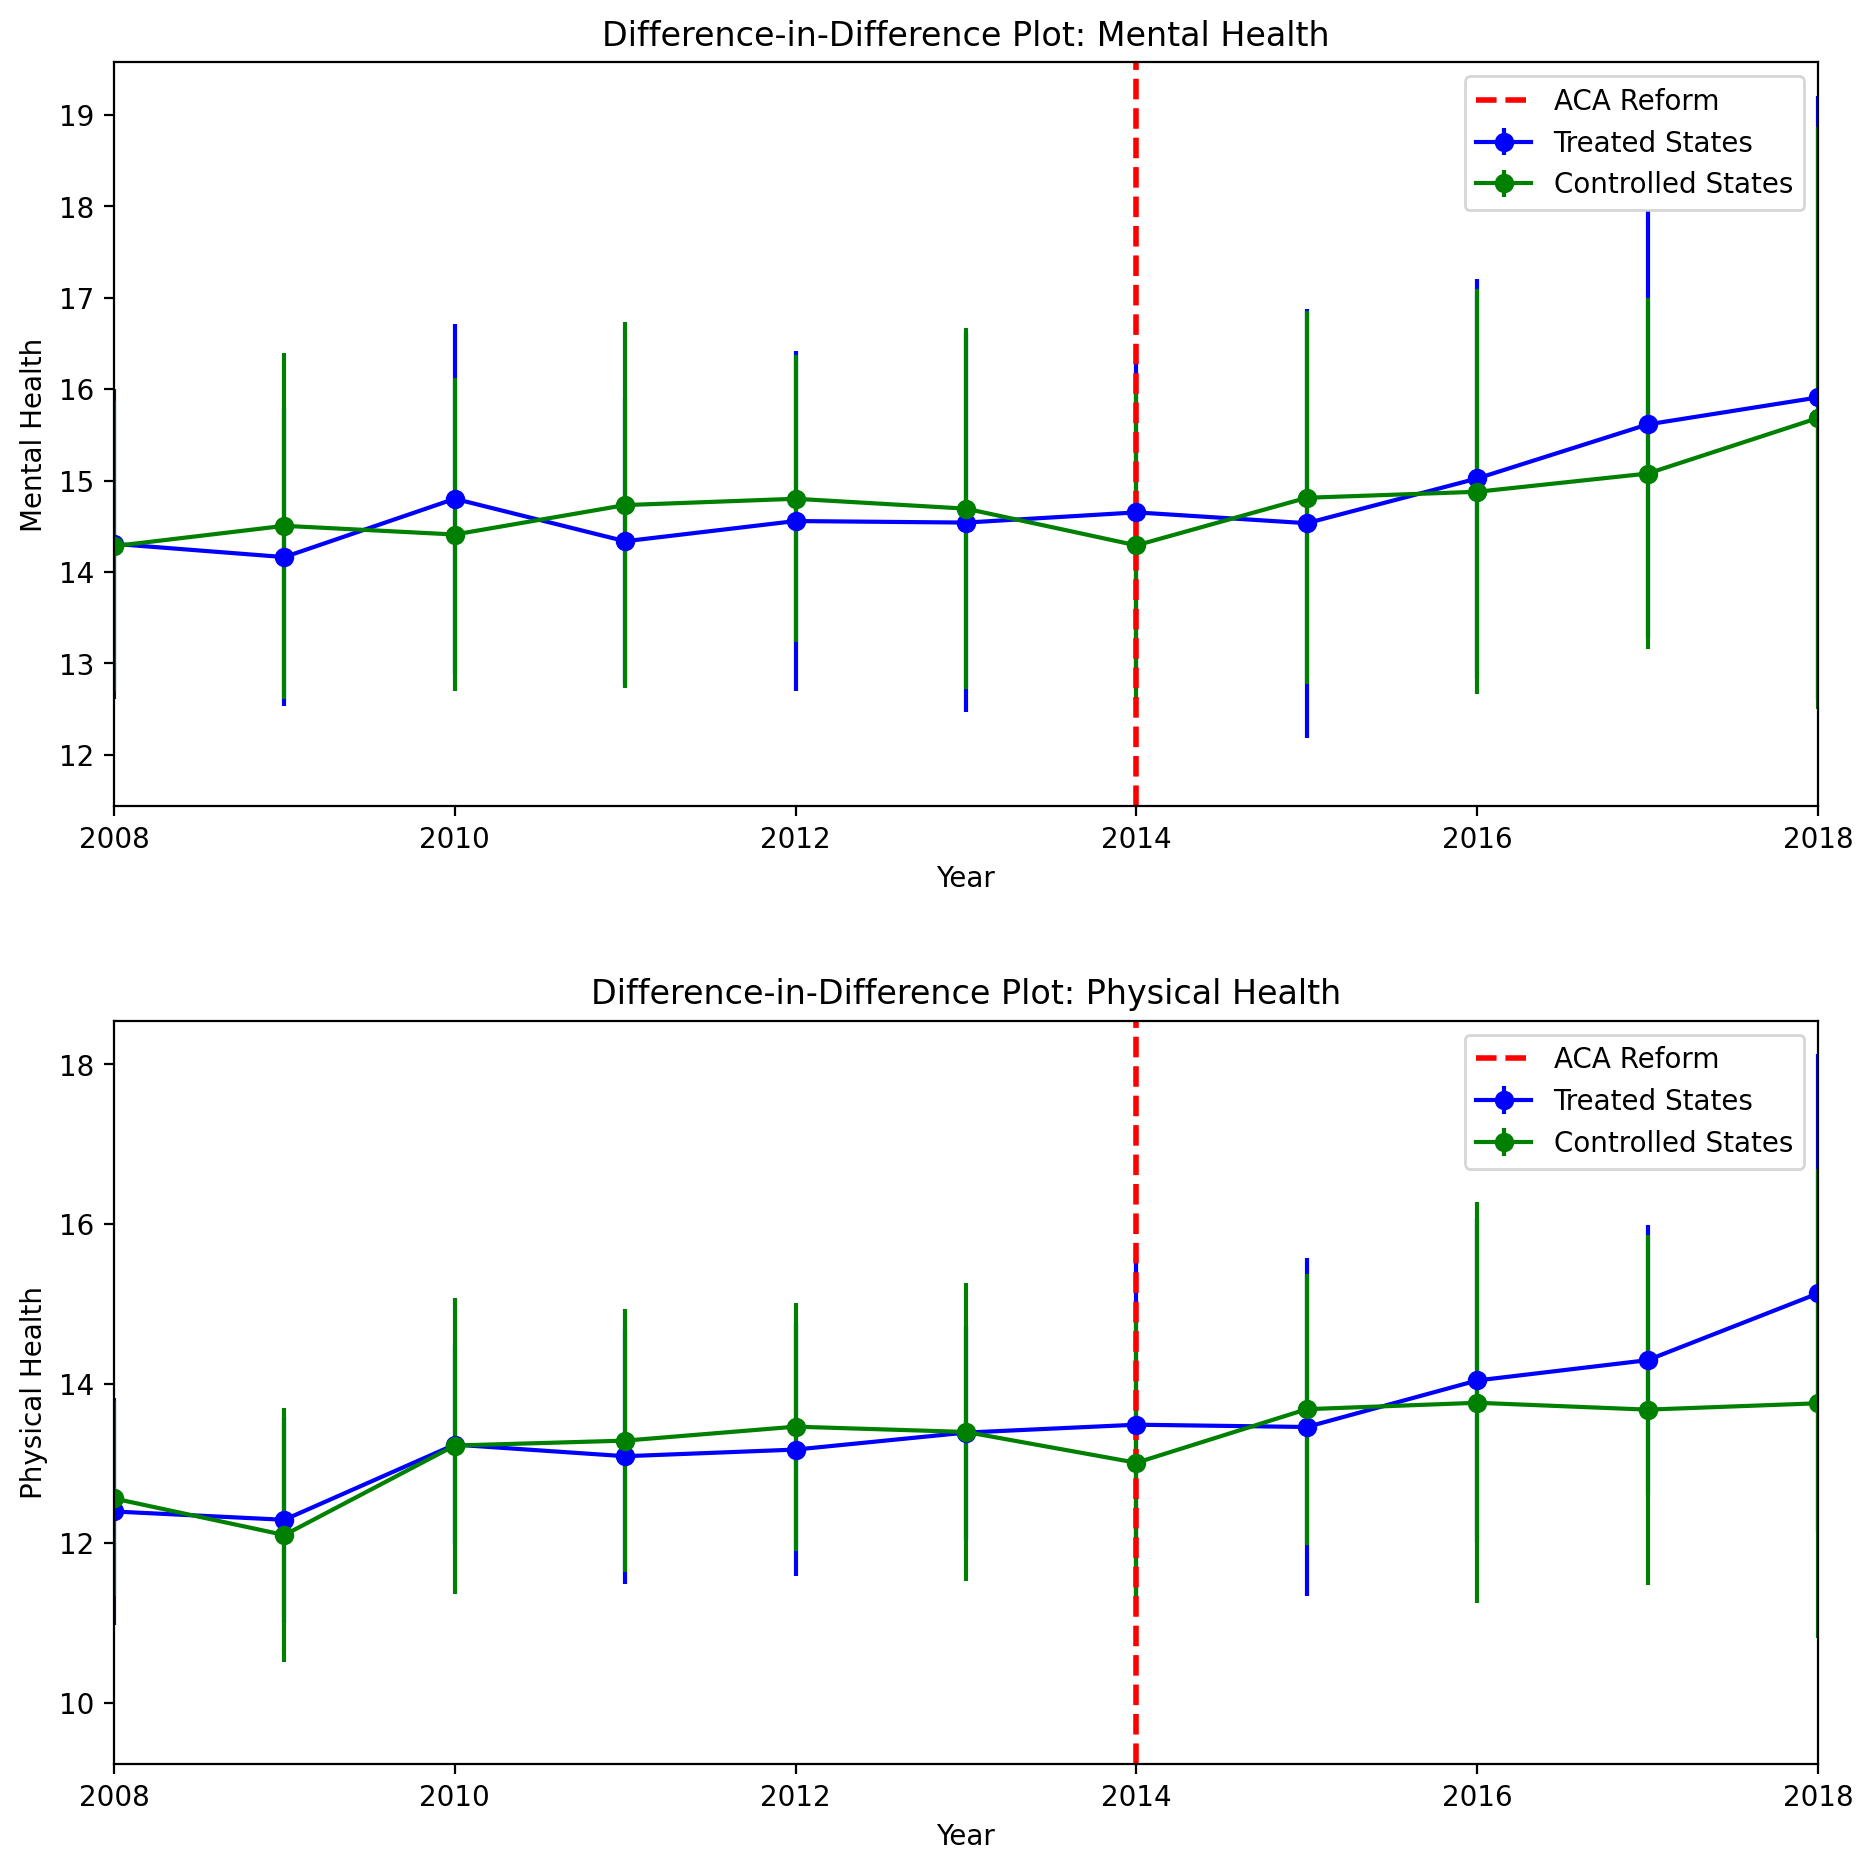

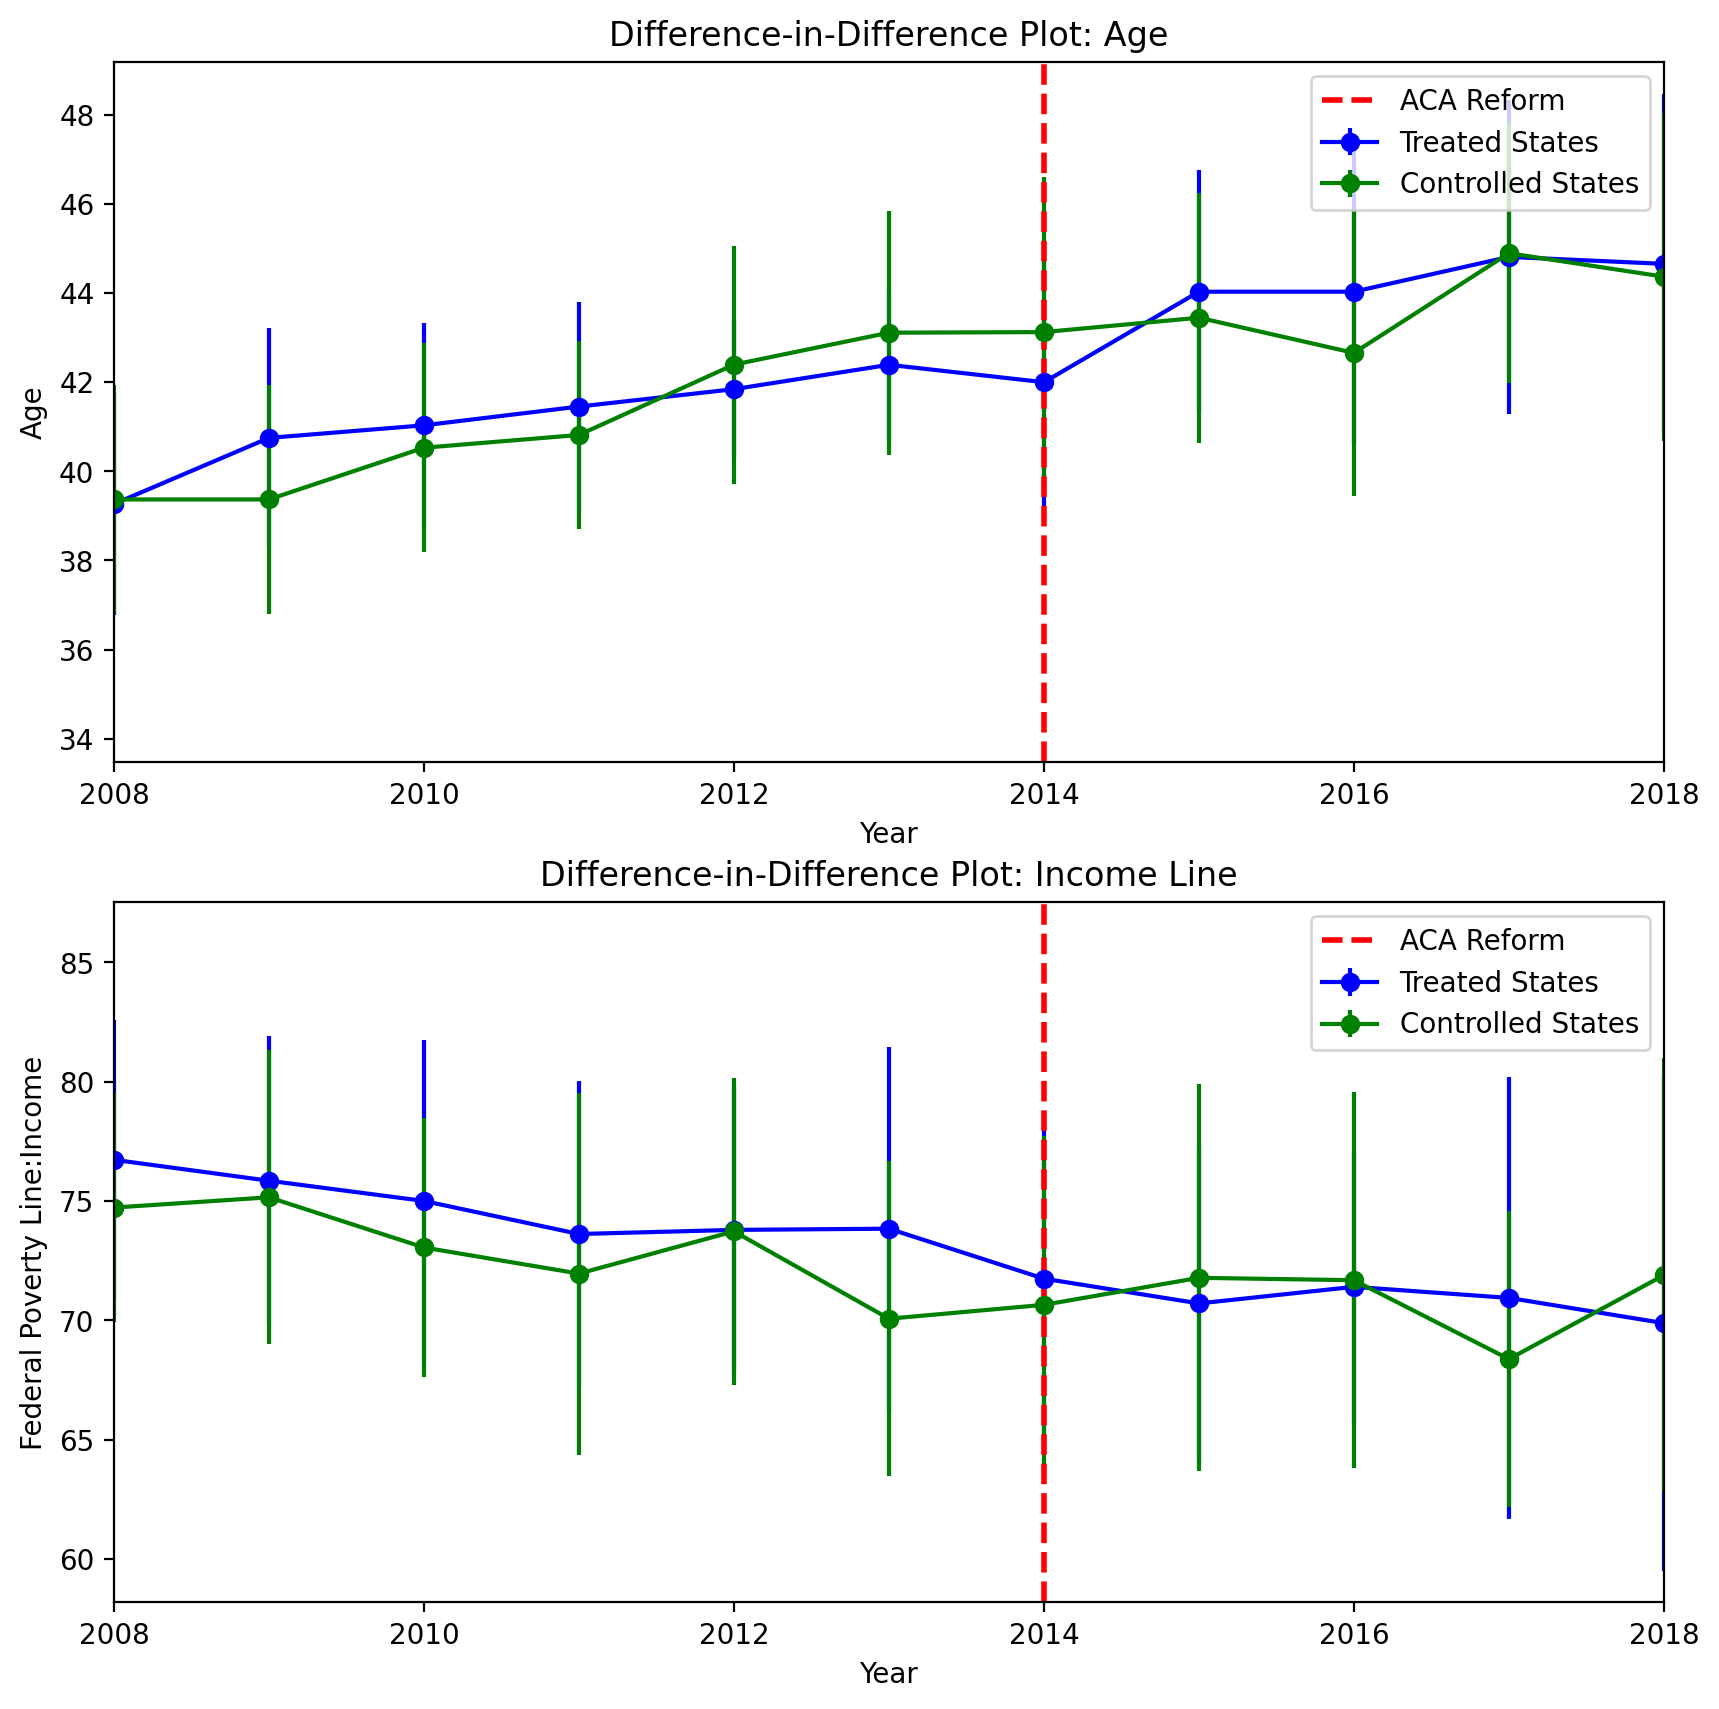

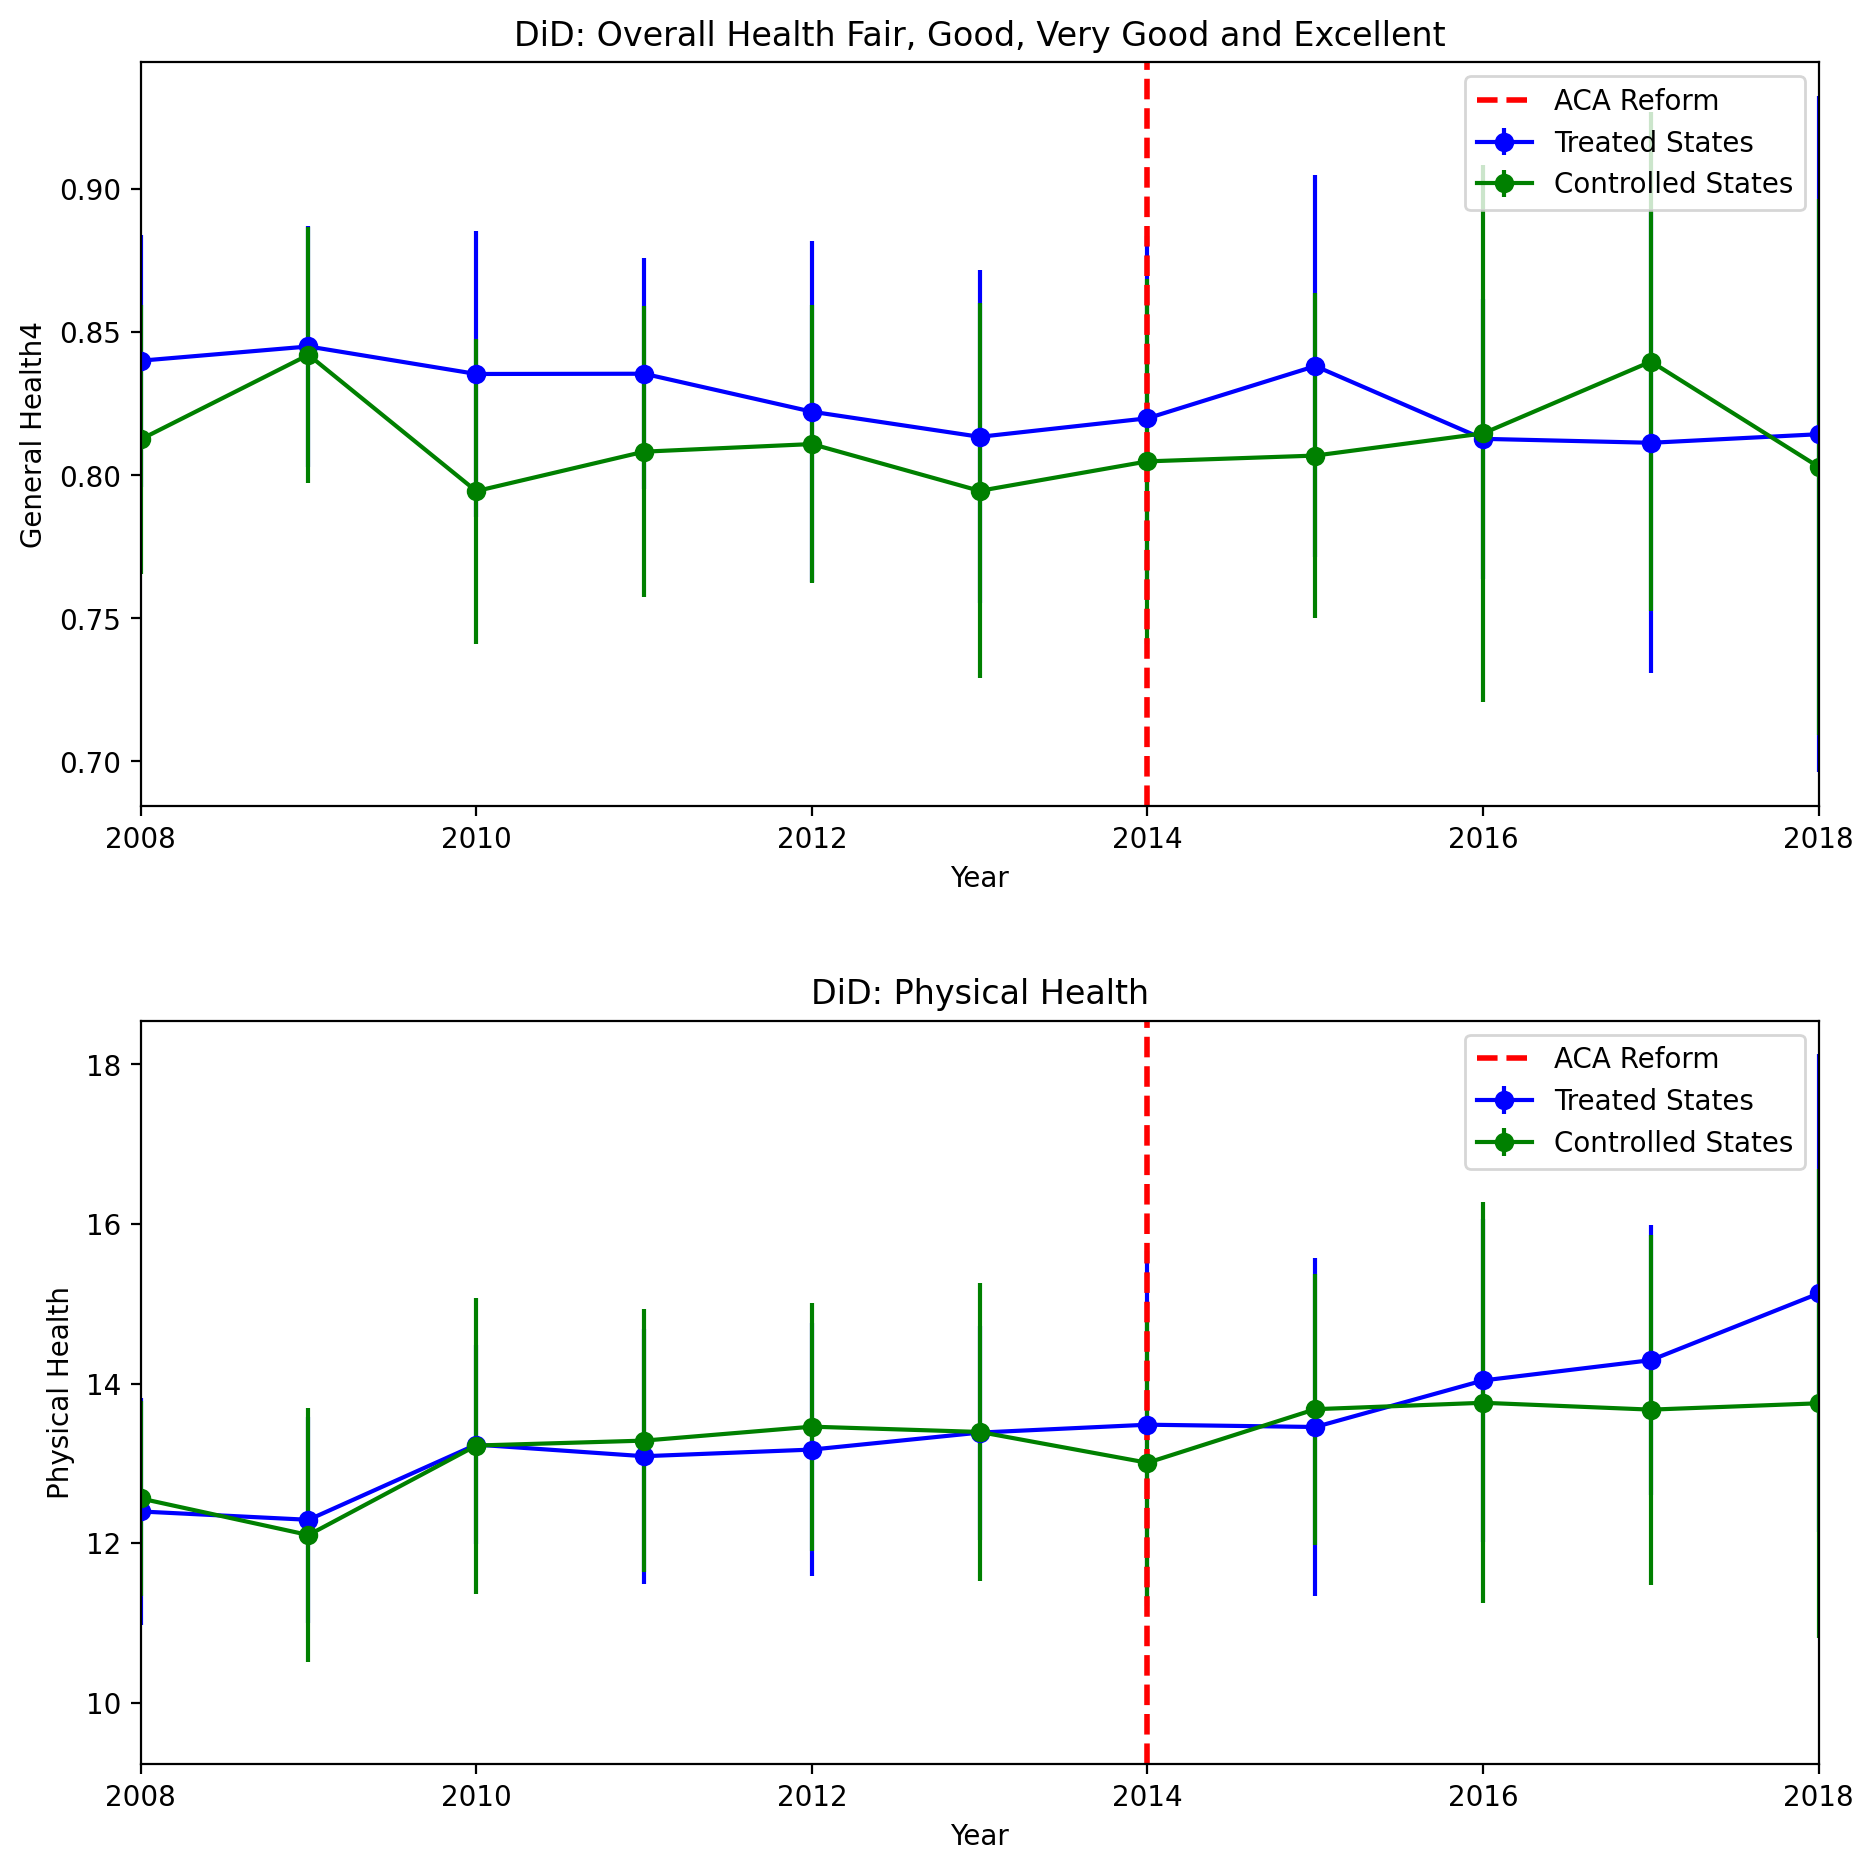

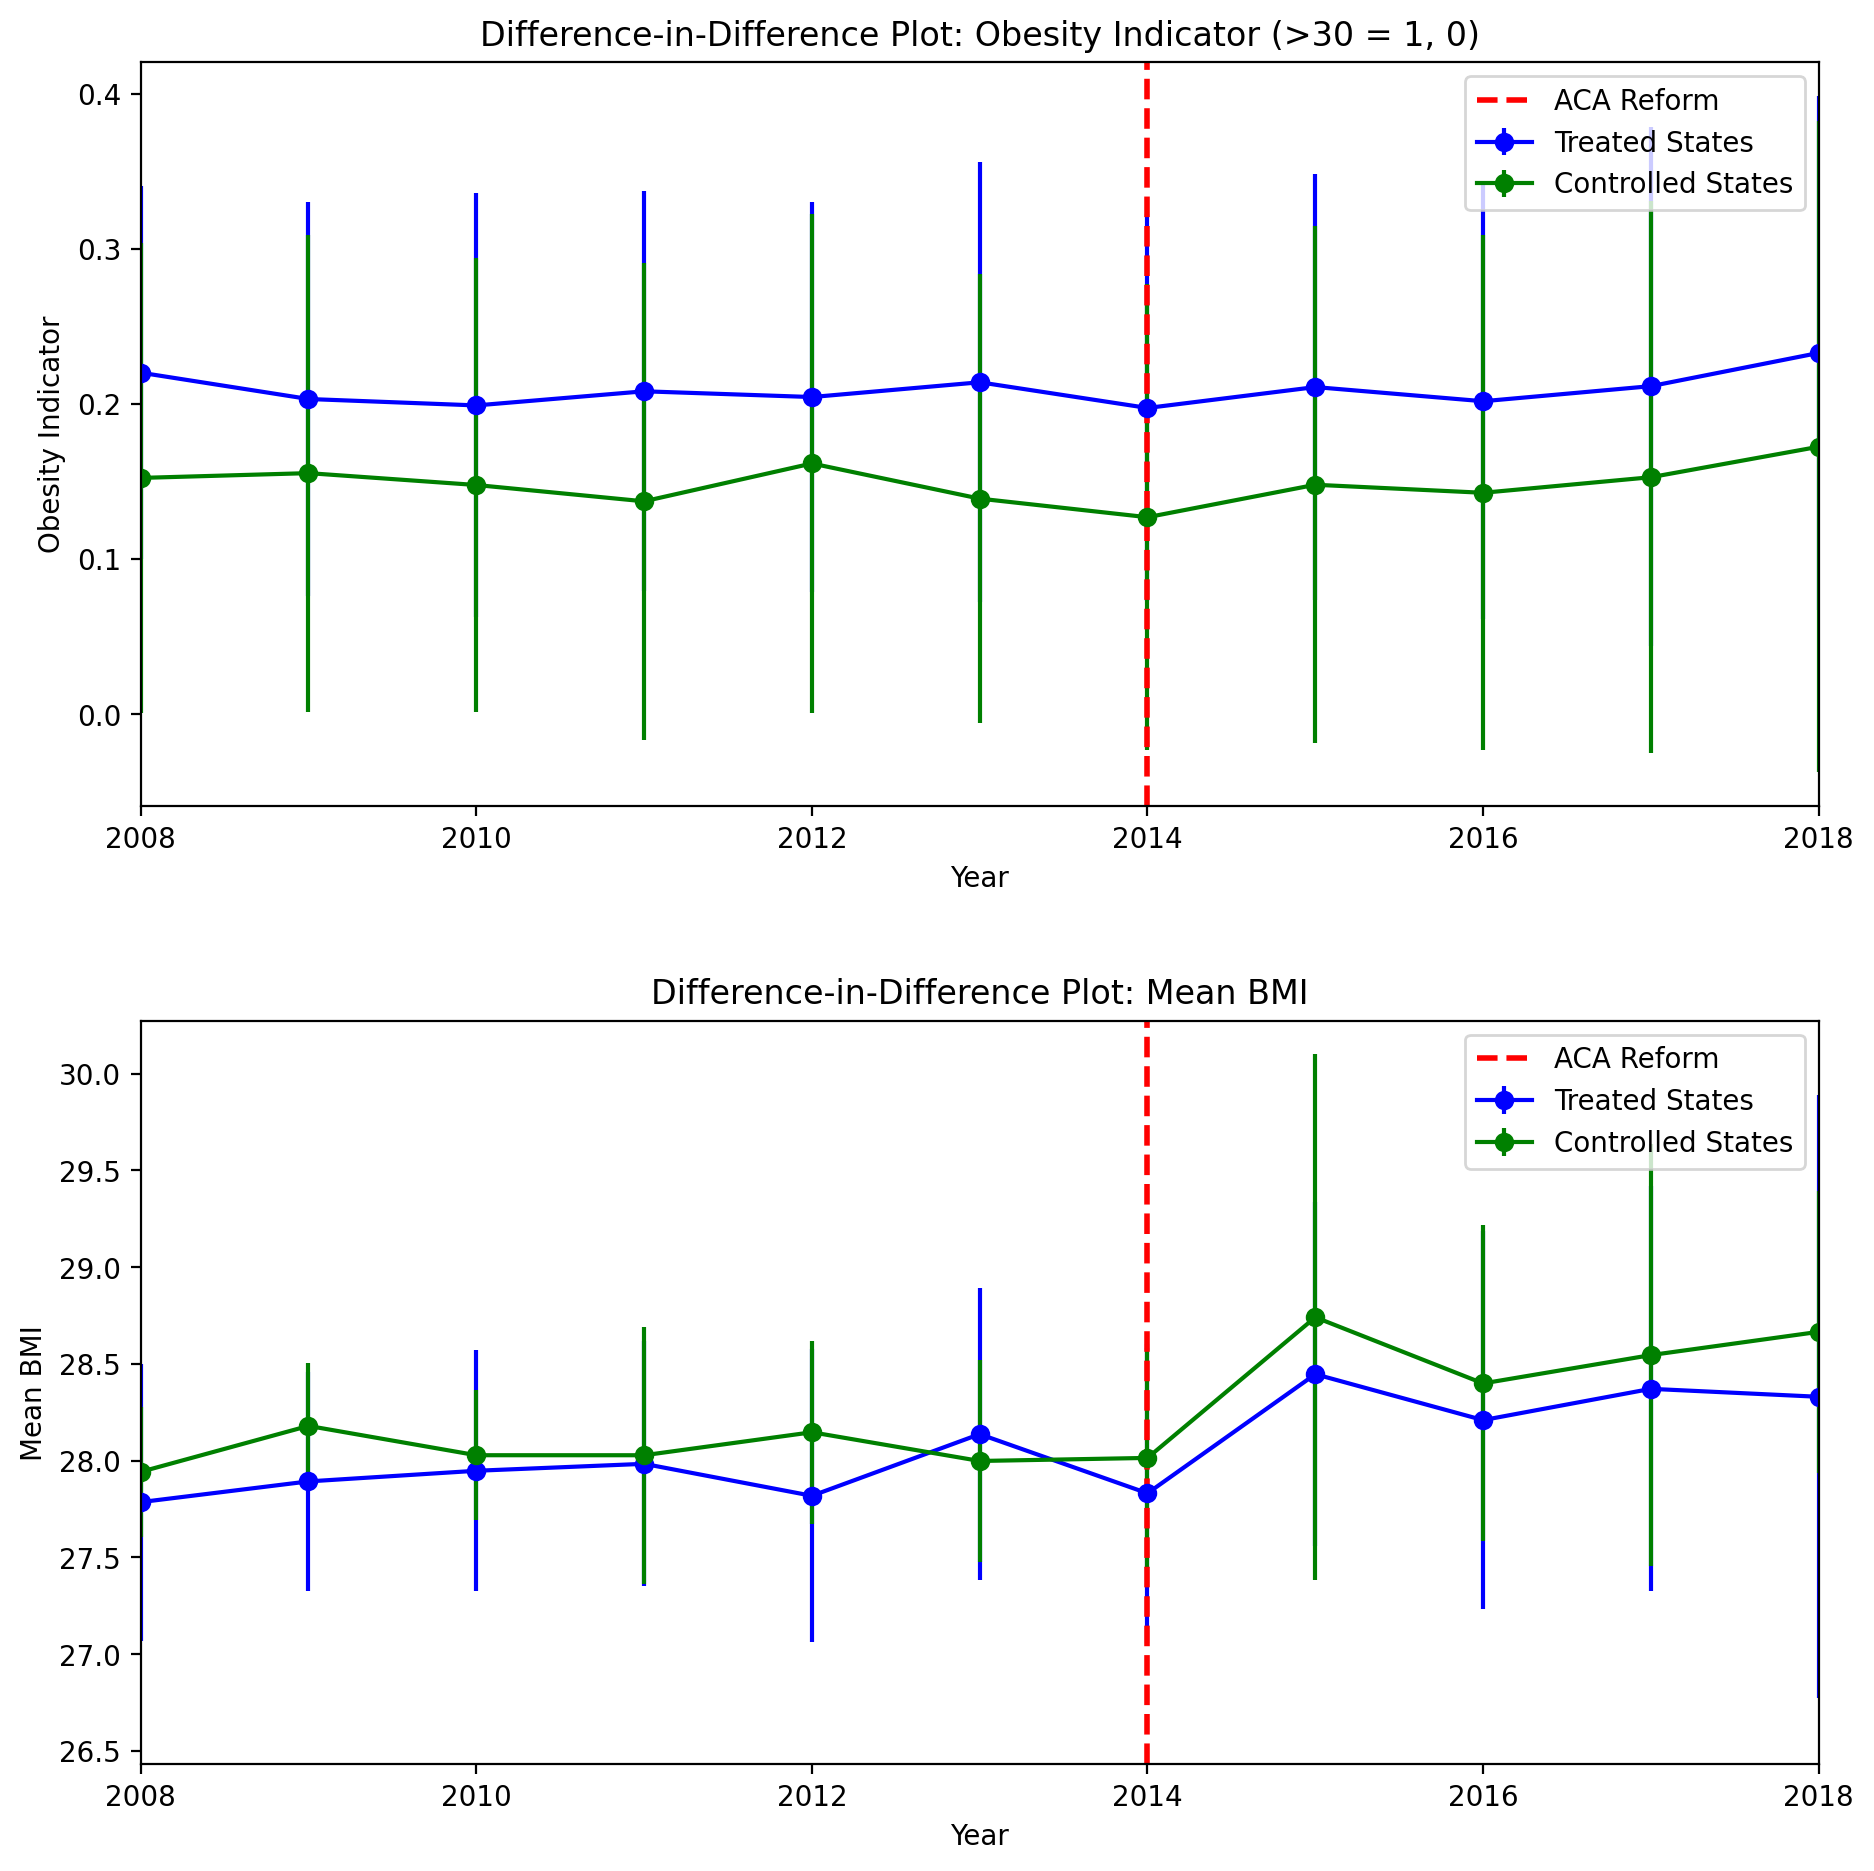

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Function to create Difference-in-Difference plots for any outcome variable
def plot_did_outcome(ax, merged_total, outcome, ylabel, treatment_year):
    # Generate the plot
    plot_df = (
        merged_total
        .assign(state_label=np.where(merged_total['treatment'], "Treated States", "Controlled States"))
        .groupby(["year", "state_label"])[outcome]
        .agg(['mean', 'std'])  # Calculating mean and standard deviation for error bars
        .reset_index()
        .pivot(index="year", columns="state_label")
    )

    # Plot mean values with error bars to reflect variability
    ax.errorbar(
        plot_df.index, plot_df['mean', 'Treated States'],
        yerr=plot_df['std', 'Treated States'],
        label='Treated States', color='blue', linestyle='-', marker='o'
    )
    ax.errorbar(
        plot_df.index, plot_df['mean', "Controlled States"],
        yerr=plot_df['std', "Controlled States"],
        label='Controlled States', color='green', linestyle='-', marker='o'
    )

    # Set x-axis limits to show only years 2008-2018
    ax.set_xlim(2008, 2018)

    # Set labels and a vertical line to mark the treatment year
    ax.set_xlabel('Year')
    ax.set_ylabel(ylabel)
    ax.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label="ACA Reform")
    ax.legend()

### Figure 1: Physical and Mental Health ###
fig1, axs1 = plt.subplots(2, 1, figsize=(10, 10))

# Plot avg_mental_health in the first subplot
plot_did_outcome(axs1[0], merged_total, 'avg_mental_health', 'Mental Health', 2014)

# Plot avg_physical_health in the second subplot
plot_did_outcome(axs1[1], merged_total, 'avg_physical_health', 'Physical Health', 2014)

# Add titles to the subplots
axs1[0].set_title('Difference-in-Difference Plot: Mental Health')
axs1[1].set_title('Difference-in-Difference Plot: Physical Health')

# Adjust layout to avoid overlap
plt.tight_layout(pad=3.0)

# Save the figure for Overleaf
plt.savefig('/content/drive/MyDrive/econ191/figures/did_mediciad_eligibility.png', format='png')

# Show the plots
plt.show()


fig0, axs0 = plt.subplots(2, 1, figsize=(10, 10))
plot_did_outcome(axs0[0], merged_total, 'age', 'Age', 2014)
#plot_did_outcome(axs0[1], merged_total, 'avg_household_size', 'Household size', 2014)
#plot_did_outcome(axs0[2], merged_total, 'avg_adult', 'Adults', 2014)
plot_did_outcome(axs0[1], merged_total, 'avg_income_percent_fpl', 'Federal Poverty Line:Income', 2014)


# Add titles to the subplots
axs0[0].set_title('Difference-in-Difference Plot: Age')
#axs0[1].set_title('Difference-in-Difference Plot: Household size')
#axs0[2].set_title('Difference-in-Difference Plot: individual Adults')
axs0[1].set_title('Difference-in-Difference Plot: Income Line')


# Save the figure for Overleaf
plt.savefig('/content/drive/MyDrive/econ191/figures/did_demographic.png', format='png')

# Show the plots
plt.show()


### Figure 2: General Health Indicators ###
fig2, axs2 = plt.subplots(2, 1, figsize=(10, 10))


# Plot general health binary 3 in the third subplot
plot_did_outcome(axs2[0], merged_total, 'gen_health_binary4', 'General Health4', 2014)

plot_did_outcome(axs2[1], merged_total, 'avg_physical_health', 'Physical Health', 2014)


# Add titles to the subplots
axs2[0].set_title('DiD: Overall Health Fair, Good, Very Good and Excellent')
axs2[1].set_title('DiD: Physical Health')



# Adjust layout to avoid overlap
plt.tight_layout(pad=3.0)

# Save the figure for Overleaf
plt.savefig('/content/drive/MyDrive/econ191/figures/did_general_health.png', format='png')

# Show the plots
plt.show()


### Figure 3: BMI Indicators ###
fig3, axs3 = plt.subplots(2, 1, figsize=(10, 10))

# Plot BMI indicator in the first subplot
plot_did_outcome(axs3[0], merged_total, 'bmi_indicator', 'Obesity Indicator', 2014)

# Plot Mean BMI in the second subplot
plot_did_outcome(axs3[1], merged_total, 'avg_bmi', 'Mean BMI', 2014)

# Add titles to the subplots
axs3[0].set_title('Difference-in-Difference Plot: Obesity Indicator (>30 = 1, 0)')
axs3[1].set_title('Difference-in-Difference Plot: Mean BMI')

# Adjust layout to avoid overlap
plt.tight_layout(pad=3.0)

# Save the figure for Overleaf
plt.savefig('/content/drive/MyDrive/econ191/figures/did_bmi.png', format='png')

# Show the plots
plt.show()


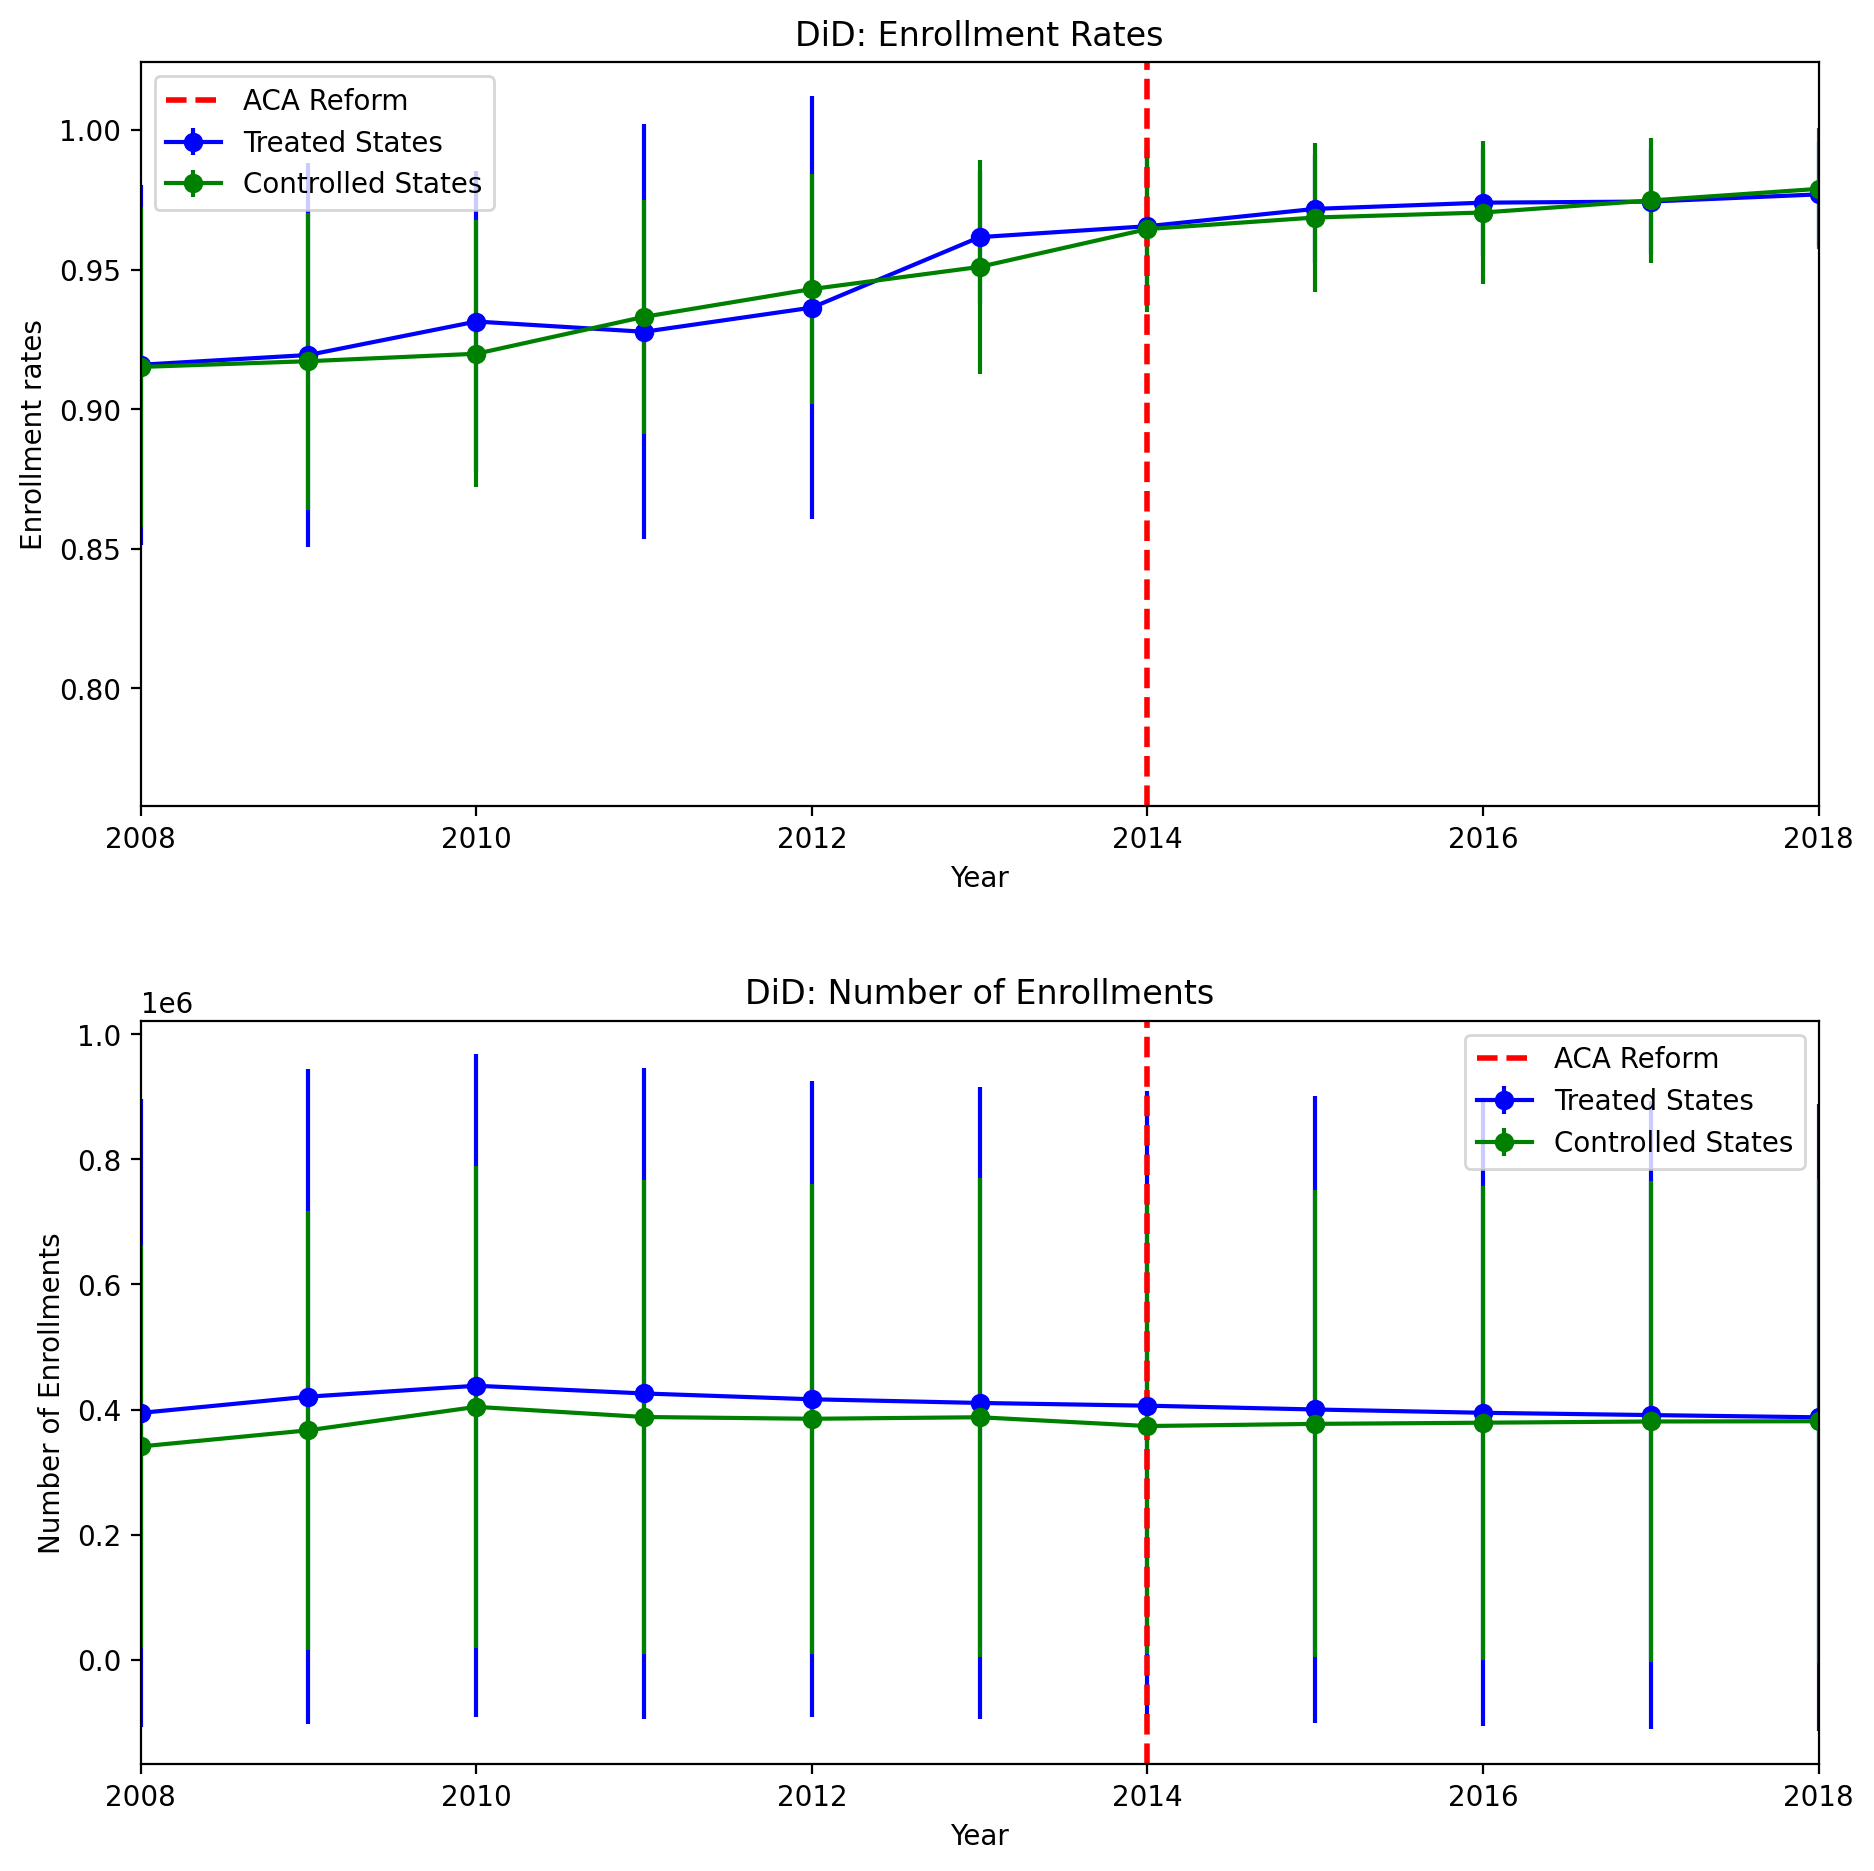

In [45]:
### Figure 2: General Health Indicators ###
fig5, axs5 = plt.subplots(2, 1, figsize=(10, 10))

# Plot general health binary 2 in the second subplot
plot_did_outcome(axs5[0], merged_total, 'enrollment_rate', 'Enrollment rates', 2014)

# Plot general health binary 3 in the third subplot
plot_did_outcome(axs5[1], merged_total, 'nof_enrollments', 'Number of Enrollments', 2014)

# Add titles to the subplots
axs5[0].set_title('DiD: Enrollment Rates')
axs5[1].set_title('DiD: Number of Enrollments')

# Adjust layout to avoid overlap
plt.tight_layout(pad=3.0)

# Save the figure for Overleaf
plt.savefig('/content/drive/MyDrive/econ191/figures/did_enrollment.png', format='png')

# Show the plots
plt.show()

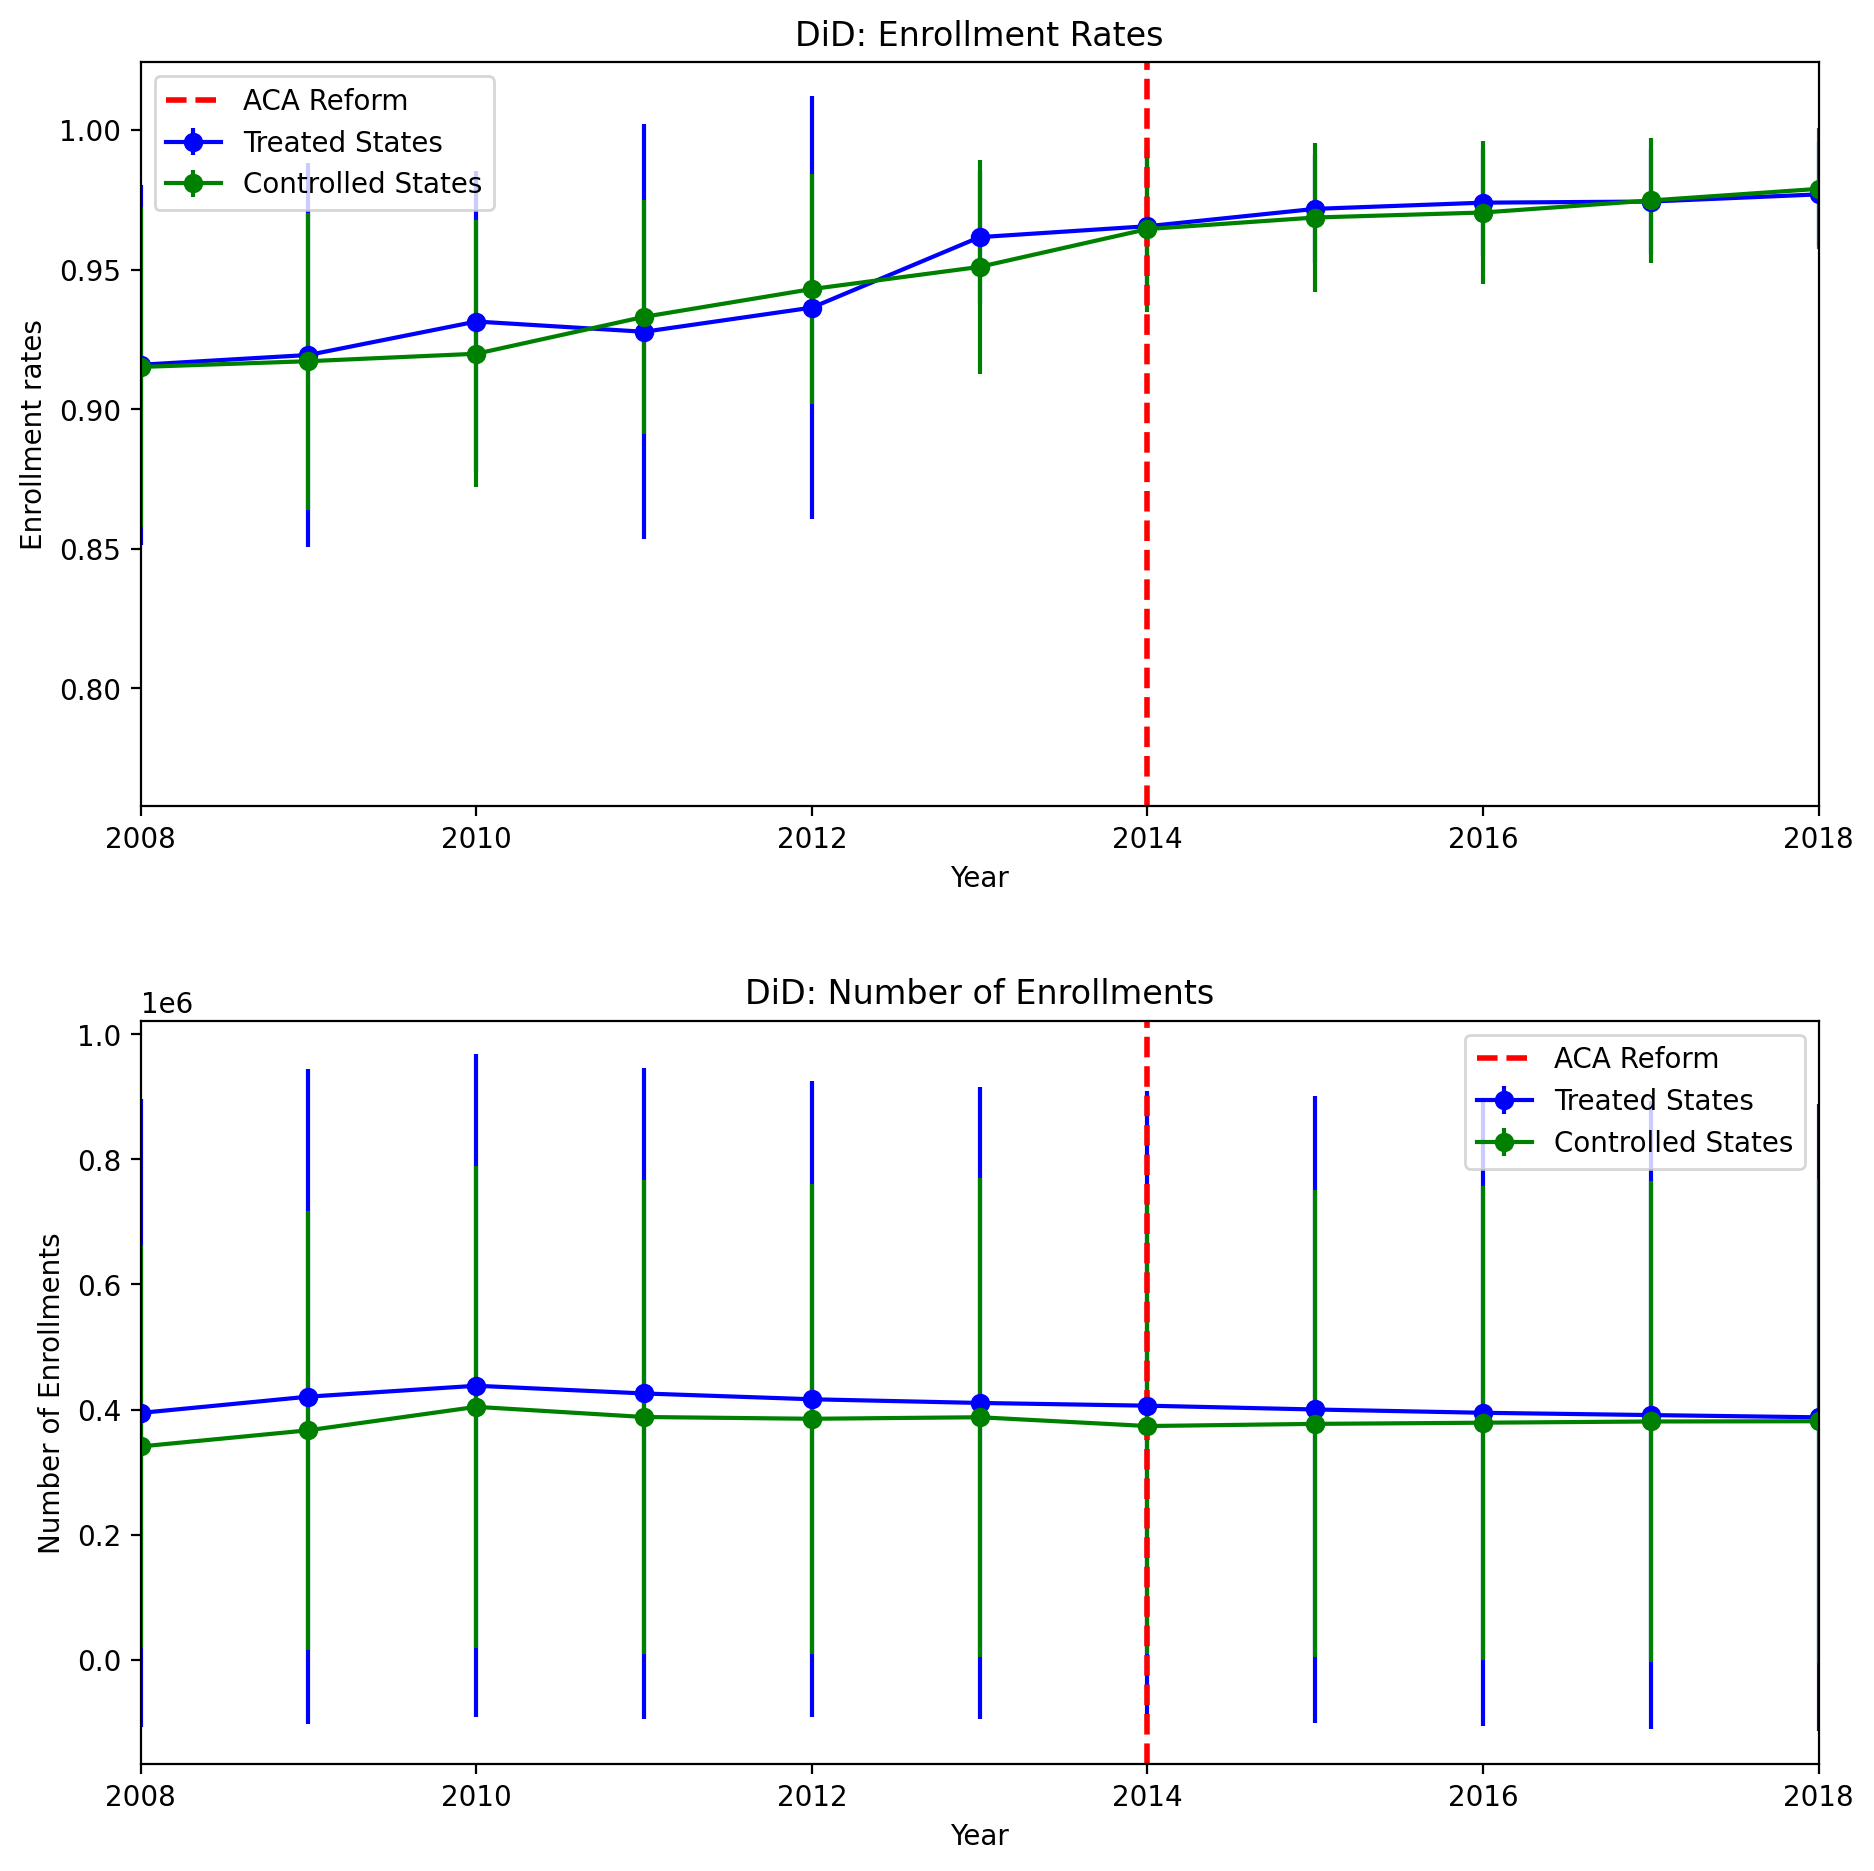

In [46]:
### Figure 2: General Health Indicators ###
fig5, axs5 = plt.subplots(2, 1, figsize=(10, 10))

# Plot general health binary 2 in the second subplot
plot_did_outcome(axs5[0], merged_total, 'enrollment_rate', 'Enrollment rates', 2014)

# Plot general health binary 3 in the third subplot
plot_did_outcome(axs5[1], merged_total, 'nof_enrollments', 'Number of Enrollments', 2014)

# Add titles to the subplots
axs5[0].set_title('DiD: Enrollment Rates')
axs5[1].set_title('DiD: Number of Enrollments')

# Adjust layout to avoid overlap
plt.tight_layout(pad=3.0)

# Save the figure for Overleaf
plt.savefig('/content/drive/MyDrive/econ191/figures/did_enrollment.png', format='png')

# Show the plots
plt.show()

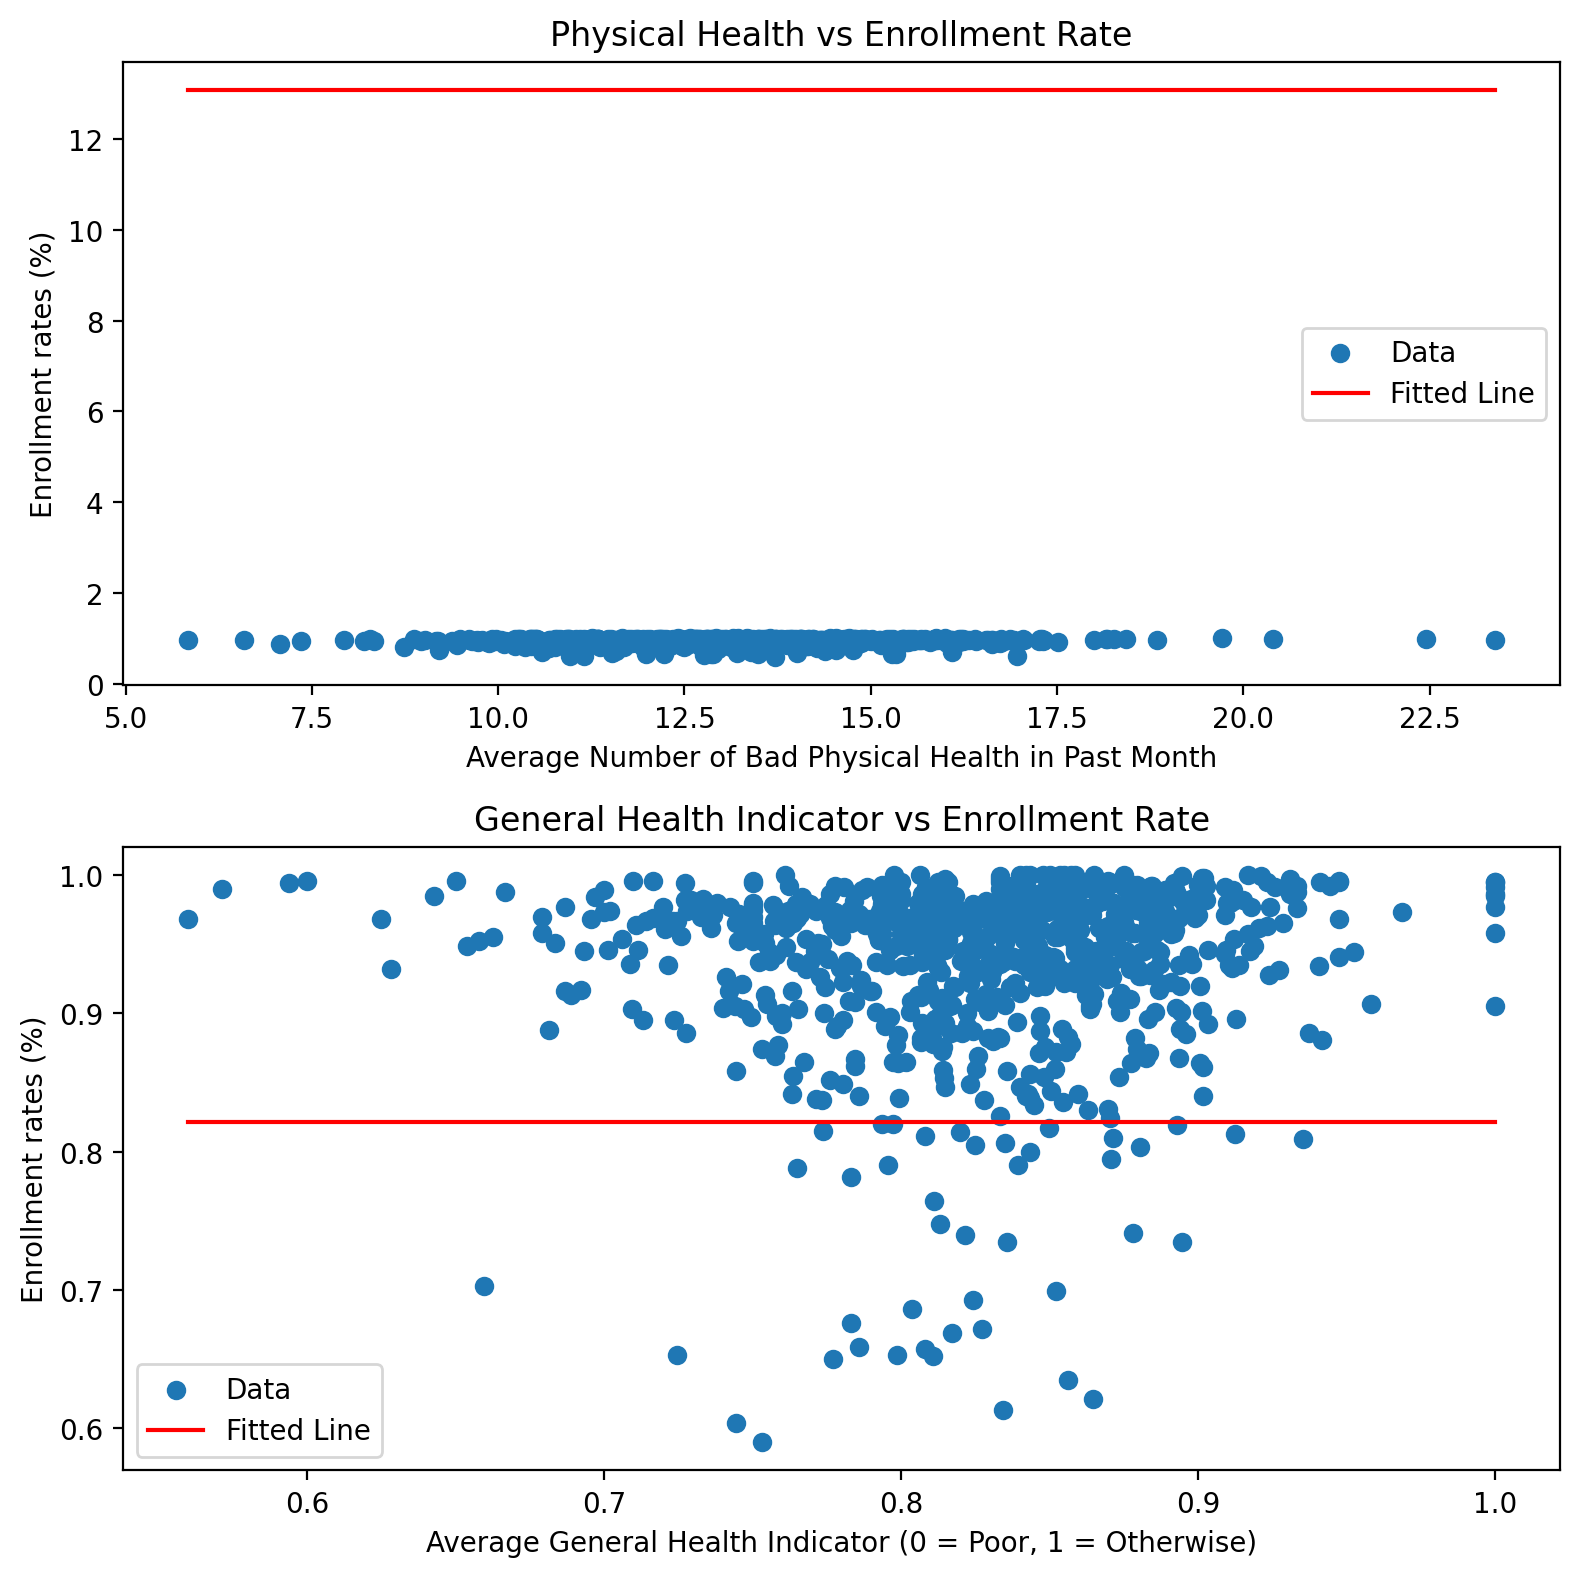

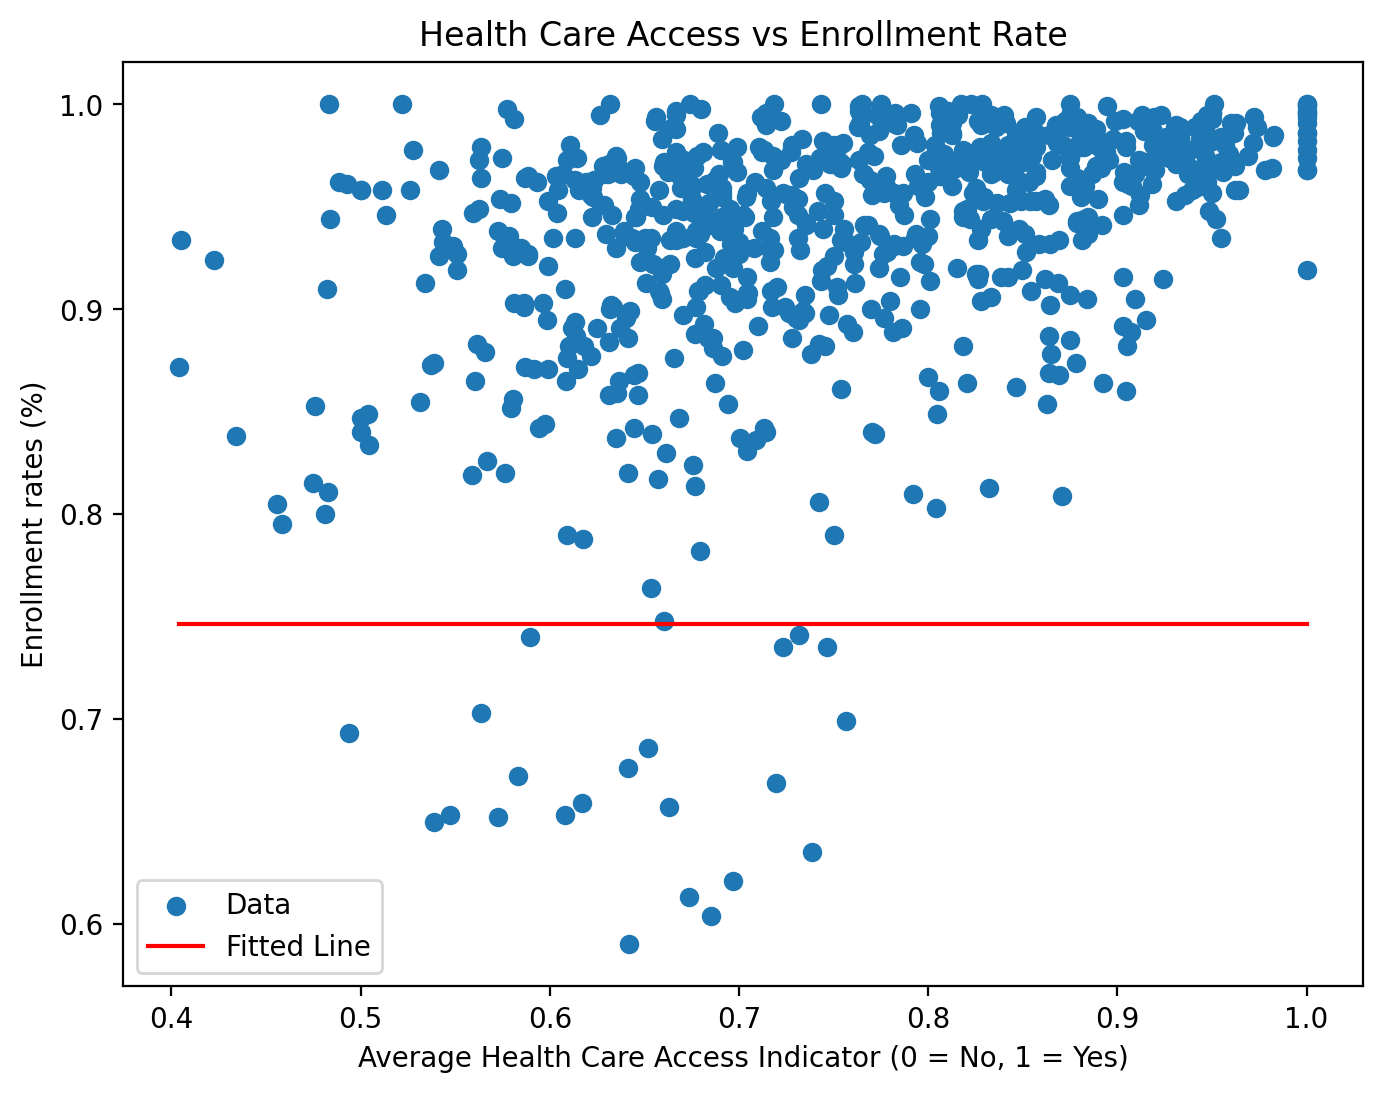

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# First stage formulas
formula1 = "avg_health_access ~ treatment + pre_post + did"
formula2 = "avg_physical_health ~ treatment + pre_post + did"
formula3 = "gen_health_binary4 ~ treatment + pre_post + did"

# Fit weighted least squares (WLS) models
model1 = smf.wls(formula1, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model2 = smf.wls(formula2, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model3 = smf.wls(formula3, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})

# Generate a range of x-values for smooth fitted lines
x_vals_health_access = np.linspace(merged_total['avg_health_access'].min(), merged_total['avg_health_access'].max(), 100)
x_vals_physical_health = np.linspace(merged_total['avg_physical_health'].min(), merged_total['avg_physical_health'].max(), 100)
x_vals_general_health = np.linspace(merged_total['gen_health_binary4'].min(), merged_total['gen_health_binary4'].max(), 100)

# Create DataFrames for predictions
predict_health_access = pd.DataFrame({
    'avg_health_access': x_vals_health_access,
    'treatment': merged_total['treatment'].mean(),
    'pre_post': merged_total['pre_post'].mean(),
    'did': merged_total['did'].mean(),
    'age': merged_total['age'].mean()
})

predict_physical_health = pd.DataFrame({
    'avg_physical_health': x_vals_physical_health,
    'treatment': merged_total['treatment'].mean(),
    'pre_post': merged_total['pre_post'].mean(),
    'did': merged_total['did'].mean(),
    'age': merged_total['age'].mean()
})

predict_general_health = pd.DataFrame({
    'gen_health_binary4': x_vals_general_health,
    'treatment': merged_total['treatment'].mean(),
    'pre_post': merged_total['pre_post'].mean(),
    'did': merged_total['did'].mean(),
    'age': merged_total['age'].mean()
})

# Scatter plot with properly smoothed fitted lines
fig6, axs6 = plt.subplots(2, 1, figsize=(8, 8))

# Scatter plot and smoothed fitted line for avg_physical_health
axs6[0].scatter(merged_total['avg_physical_health'], merged_total['enrollment_rate'], label='Data')
fitted_physical_health = model2.predict(predict_physical_health)
axs6[0].plot(x_vals_physical_health, fitted_physical_health, color='red', label='Fitted Line')
axs6[0].set_xlabel('Average Number of Bad Physical Health in Past Month')
axs6[0].set_ylabel('Enrollment rates (%)')
axs6[0].set_title('Physical Health vs Enrollment Rate')
axs6[0].legend()

# Scatter plot and smoothed fitted line for gen_health_binary4
axs6[1].scatter(merged_total['gen_health_binary4'], merged_total['enrollment_rate'], label='Data')
fitted_general_health = model3.predict(predict_general_health)
axs6[1].plot(x_vals_general_health, fitted_general_health, color='red', label='Fitted Line')
axs6[1].set_xlabel('Average General Health Indicator (0 = Poor, 1 = Otherwise)')
axs6[1].set_ylabel('Enrollment rates (%)')
axs6[1].set_title('General Health Indicator vs Enrollment Rate')
axs6[1].legend()

# Save and show the first figure
fig6.tight_layout()
fig6.savefig('/content/drive/MyDrive/econ191/figures/scatter1.png')
plt.show()

# Scatter plot and smoothed fitted line for avg_health_access
plt.figure(figsize=(8, 6))
plt.scatter(merged_total['avg_health_access'], merged_total['enrollment_rate'], label='Data')
fitted_health_access = model1.predict(predict_health_access)
plt.plot(x_vals_health_access, fitted_health_access, color='red', label='Fitted Line')
plt.xlabel('Average Health Care Access Indicator (0 = No, 1 = Yes)')
plt.ylabel('Enrollment rates (%)')
plt.title('Health Care Access vs Enrollment Rate')
plt.legend()
plt.savefig('/content/drive/MyDrive/econ191/figures/scatter3.png')
plt.show()


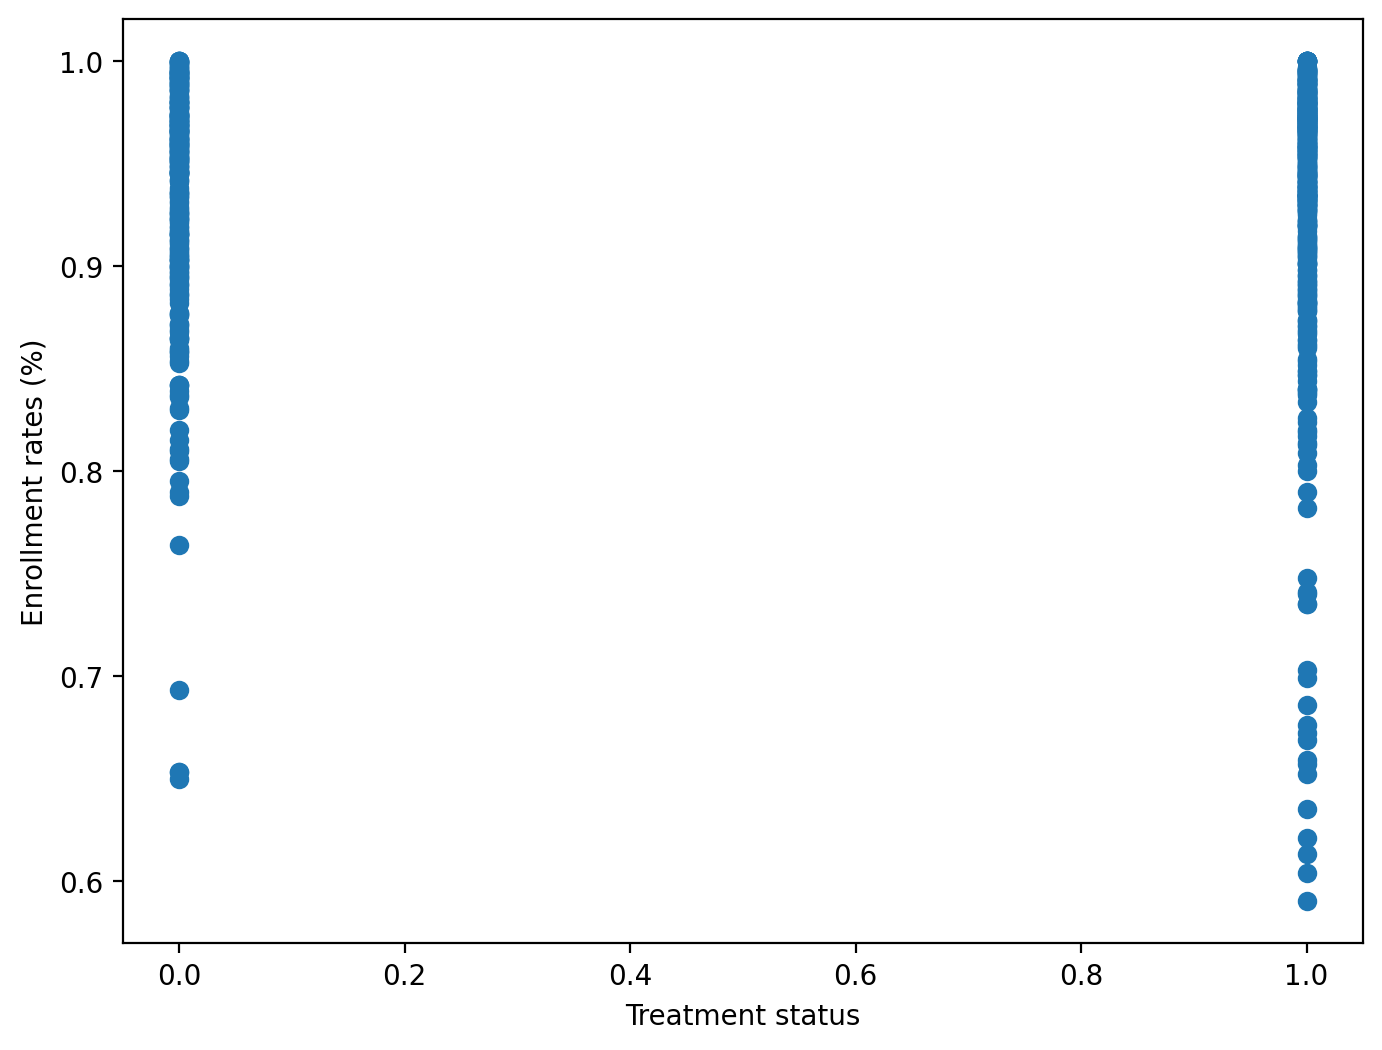

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_total['treatment'], merged_total['enrollment_rate'])
plt.xlabel('Treatment status')
plt.ylabel('Enrollment rates (%)')
plt.savefig('/content/drive/MyDrive/econ191/figures/scatter4.png')
plt.show()

In [ ]:
import statsmodels.formula.api as smf

# Define the formula for the difference-in-differences regression
formula  = "avg_physical_health ~ treatment*pre_post"
formula1 = "avg_mental_health ~ treatment*pre_post"
formula2 = "gen_health_binary1 ~ treatment*pre_post"
formula3 = "gen_health_binary2 ~ treatment*pre_post"
formula4 = "gen_health_binary3 ~ treatment*pre_post"
formula5 = "gen_health_binary4 ~ treatment*pre_post"
formula6 = "bmi_indicator ~ treatment*pre_post"
formula7 = "avg_bmi ~ treatment*pre_post"

# Fit the models with clustered standard errors
model = smf.wls(formula, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model1 = smf.wls(formula1, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model2 = smf.wls(formula2, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model3 = smf.wls(formula3, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model4 = smf.wls(formula4, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model5 = smf.wls(formula5, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model6 = smf.wls(formula6, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
model7 = smf.wls(formula7, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})


# Print the model summary
print('Difference in Difference regression results on each outcome variable')
print(model.summary())
print(model1.summary())
print(model2.summary())
print(model3.summary())
print(model4.summary())
print(model5.summary())
print(model6.summary())
print(model7.summary())

In [ ]:
## Example
## Event Study Plot for each year of generalth Health
merged_total1 = pd.get_dummies(merged_total, columns=['race'])
merged_total1.rename(columns={
    'race_asian/non-hispanic': 'race_asian_non_hispanic',
    'race_black': 'race_black',
    'race_white': 'race_white',
    'race_hispanic': 'race_hispanic',
    'race_native hawaiian/pacific islander': 'race_native_hawaiian_pacific_islander',
    'race_non-hispanic/multiracial': 'race_non_hispanic_multiracial',
    'race_other/non-hispanic': 'race_other_non_hispanic',
    'race_refused/unknown': 'race_refused_unknown'
}, inplace=True)

merged_total2 = pd.get_dummies(merged_total, columns=['age'])
print(merged_total2.columns)

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Define the formulas for the difference-in-differences regression


formulas = [
    "avg_physical_health ~ did ",
    "avg_mental_health ~ did",
    "gen_health_binary1 ~ did",
    "gen_health_binary2 ~ did",
    "gen_health_binary3 ~ did",
    "bmi_indicator ~ did"
]

# Fit the models with clustered standard errors
models = [
    smf.wls(formula, data=merged_total, weights=merged_total['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total['state']})
    for formula in formulas
]

# Combine the models into one summary table, including confidence intervals and p-values
results_table = summary_col(models, stars=True, model_names=['Physical Health', 'Mental Health', 'General Health1', 'General Health2', 'General Health3','BMI'],
                            info_dict={
                                'Confidence Interval': lambda x: f"[{x.conf_int().iloc[0,0]:.2f}, {x.conf_int().iloc[0,1]:.2f}]",
                                'p-value': lambda x: f"{x.pvalues.iloc[0]:.3f}"
                            }
                           )

# Print the combined table
print(results_table)

# Save the table to a text file for Overleaf
with open("/content/drive/MyDrive/econ191/regression/DID_regression_health.txt", "w") as f:
      f.write(results_table.as_text())

In [ ]:
merged_total1.columns

In [ ]:
"""
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Define the formulas for the difference-in-differences regression with corrected variable names
formulas = [
    "avg_physical_health ~ did + race_asian_non_hispanic + race_black + race_white + race_hispanic + race_native_hawaiian_pacific_islander + race_non_hispanic_multiracial + race_other_non_hispanic + race_refused_unknown",
    "avg_mental_health ~ did + race_asian_non_hispanic + race_black + race_white + race_hispanic + race_native_hawaiian_pacific_islander + race_non_hispanic_multiracial + race_other_non_hispanic + race_refused_unknown",
    "gen_health_binary1 ~ did + race_asian_non_hispanic + race_black + race_white + race_hispanic + race_native_hawaiian_pacific_islander + race_non_hispanic_multiracial + race_other_non_hispanic + race_refused_unknown",
    "gen_health_binary2 ~ did + race_asian_non_hispanic + race_black + race_white + race_hispanic + race_native_hawaiian_pacific_islander + race_non_hispanic_multiracial + race_other_non_hispanic + race_refused_unknown",
    "gen_health_binary3 ~ did + race_asian_non_hispanic + race_black + race_white + race_hispanic + race_native_hawaiian_pacific_islander + race_non_hispanic_multiracial + race_other_non_hispanic + race_refused_unknown",
    "bmi_indicator ~ did + race_asian_non_hispanic + race_black + race_white + race_hispanic + race_native_hawaiian_pacific_islander + race_non_hispanic_multiracial + race_other_non_hispanic + race_refused_unknown"
]

# Fit the models with clustered standard errors
models = [
    smf.wls(formula, data=merged_total1, weights=merged_total1['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total1['state']})
    for formula in formulas
]

# Combine the models into one summary table, including confidence intervals and p-values
results_table = summary_col(models, stars=True, model_names=['Physical Health', 'Mental Health', 'General Health1', 'General Health2', 'General Health3', 'BMI'],
                            info_dict={
                                'Confidence Interval': lambda x: f"[{x.conf_int().iloc[0, 0]:.2f}, {x.conf_int().iloc[0, 1]:.2f}]",
                                'p-value': lambda x: f"{x.pvalues.iloc[0]:.3f}"
                            }
                           )

# Print the combined table
print(results_table)

# Save the table to a text file for Overleaf
with open("/content/drive/MyDrive/econ191/regression/DID_regression1-1_health.txt", "w") as f:
    f.write(results_table.as_text())
"""

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Create dummy variables for age
merged_total2 = pd.get_dummies(merged_total, columns=['age'])

# Rename columns with periods to underscores
merged_total2.columns = [col.replace('.', '_') for col in merged_total2.columns]

# List all age dummy columns (after renaming)
age_dummies = [col for col in merged_total2.columns if 'age_group' in col]

# Construct the formulas for regression including all age dummies and treatment variable 'did'
formulas = [
    "avg_physical_health ~ did + " + " + ".join(age_dummies),
    "avg_mental_health ~ did + " + " + ".join(age_dummies),
    "gen_health_binary1 ~ did + " + " + ".join(age_dummies),
    "gen_health_binary2 ~ did + " + " + ".join(age_dummies),
    "gen_health_binary3 ~ did + " + " + ".join(age_dummies),
    "bmi_indicator ~ did + " + " + ".join(age_dummies)
]

# Fit the models with clustered standard errors
models = [
    smf.wls(formula, data=merged_total2, weights=merged_total2['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total2['state']})
    for formula in formulas
]

# Combine the models into one summary table, including confidence intervals and p-values
results_table = summary_col(models, stars=True, model_names=['Physical Health', 'Mental Health', 'General Health1', 'General Health2', 'General Health3', 'BMI'],
                            info_dict={
                                'Confidence Interval': lambda x: f"[{x.conf_int().iloc[0, 0]:.2f}, {x.conf_int().iloc[0, 1]:.2f}]",
                                'p-value': lambda x: f"{x.pvalues.iloc[0]:.3f}"
                            }
                           )

# Print the combined table
print(results_table)

# Save the table to a text file for Overleaf
with open("/content/drive/MyDrive/econ191/regression/DID_regression2-1_health.txt", "w") as f:
    f.write(results_table.as_text())


In [ ]:
merged_total['nof_enrollments'] = merged_total['nof_enrollments'].str.replace(',', '').astype(float)
merged_total['enrollment_rate'] = merged_total['enrollment_rate'].str.rstrip('%').astype(float)

In [ ]:
merged_total.rename(columns={'enrollment_rate(%)': 'enrollment_rate'}, inplace=True)
merged_total.columns

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

formulas = [
    "nof_enrollments ~ avg_physical_health + " + " + ".join(age_dummies),
    "enrollment_rate ~ avg_physical_health + " + " + ".join(age_dummies),

    "nof_enrollments ~ avg_mental_health + " + " + ".join(age_dummies),
    "enrollment_rate ~ avg_mental_health + " + " + ".join(age_dummies),

    "nof_enrollments ~ gen_health_binary1 + " + " + ".join(age_dummies),
    "enrollment_rate  ~ gen_health_binary1 + " + " + ".join(age_dummies),

    "nof_enrollments ~ gen_health_binary2 + " + " + ".join(age_dummies),
    "enrollment_rate ~ gen_health_binary2 + " + " + ".join(age_dummies),

    "nof_enrollments  ~ gen_health_binary3 + " + " + ".join(age_dummies),
    "enrollment_rate ~ gen_health_binary3 + " + " + ".join(age_dummies),

    "nof_enrollments ~ bmi_indicator + " + " + ".join(age_dummies),
    "enrollment_rate ~ bmi_indicator + " + " + ".join(age_dummies)
]


# Split the formulas into two smaller parts
formulas_part1 = formulas[:6]  # First half of the formulas
formulas_part2 = formulas[6:]  # Second half of the formulas

# Fit the models for the first half
models_part1 = [
    smf.wls(formula, data=merged_total2, weights=merged_total2['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total2['state']})
    for formula in formulas_part1
]

# Fit the models for the second half
models_part2 = [
    smf.wls(formula, data=merged_total2, weights=merged_total2['records']).fit(cov_type='cluster', cov_kwds={'groups': merged_total2['state']})
    for formula in formulas_part2
]

# Combine the models for the first part into one summary table
results_table_part1 = summary_col(models_part1, stars=True, model_names=['Nof_enrollments', 'enrollment_rates', 'Nof_enrollments', 'enrollment_rates', 'Nof_enrollments', 'enrollment_rates'],
                                  info_dict={
                                      'Coef. (95% CI)': lambda x: f"{x.params.iloc[1]:.2f} [{x.conf_int().iloc[1, 0]:.2f}, {x.conf_int().iloc[1, 1]:.2f}]",
                                      'p-value': lambda x: f"{x.pvalues.iloc[1]:.3f}"
                                  })

# Combine the models for the second part into another summary table
results_table_part2 = summary_col(models_part2, stars=True, model_names=['Nof_enrollments', 'enrollment_rates', 'Nof_enrollments', 'enrollment_rates', 'Nof_enrollments', 'enrollment_rates'],
                                  info_dict={
                                      'Coef. (95% CI)': lambda x: f"{x.params.iloc[1]:.2f} [{x.conf_int().iloc[1, 0]:.2f}, {x.conf_int().iloc[1, 1]:.2f}]",
                                      'p-value': lambda x: f"{x.pvalues.iloc[1]:.3f}"
                                  })

# Print the two tables
print("Results Table Part 1:")
print(results_table_part1)
print("\nResults Table Part 2:")
print(results_table_part2)

# Save the tables to text files for Overleaf
with open("/content/drive/MyDrive/econ191/regression/regression_healthoutcomes_part1.txt", "w") as f:
    f.write(results_table_part1.as_text())

with open("/content/drive/MyDrive/econ191/regression/regression_healthoutcomes_part2.txt", "w") as f:
    f.write(results_table_part2.as_text())


In [ ]:
# Scatter plot of Health care access and enrollment rates

## Data Exploration
  - Summary Statistics
  - Correlation plot(Scatter Plot)

## Data Analysis
  - Lead/Lag Analysis
  - Placebo effects
  

In [ ]:
# Summary Statistics
merged_total.describe()

In [ ]:
# Outputting the regression results
merged_total.describe().to_latex('/content/drive/MyDrive/econ191/latex/summary_statistics.tex')
# Save summary statistics as a LaTeX table for Overleaf
with open('summary_statistics.tex', 'w') as f:
    f.write(merged_total.describe().to_latex())

In [ ]:
## Histogram
"""
# Define a dictionary to map race categories to valid colors
category_to_color = {
    'white': 'blue',
    'hispanic': 'red',
    'american indian/alaskan native': 'orange',
    'black': 'green',
    'non-hispanic/multiracial': 'purple',
    'other/non-hispanic': 'brown',
    'native hawaiian/pacific islander': 'pink'
}
treat_category = {
    1 : 'blue',
    0 : 'green'
}


# Plotting the distribution of lower-income groups by race
plt.figure(figsize=(10, 6))
for race_category, color in category_to_color.items():
    subset = merged_total[merged_total['race'] == race_category]
    plt.hist(subset['avg_income_percent_fpl'], bins=15, color=color, alpha=0.5, label=race_category)

plt.title('Distribution of Lower-Income Groups (%) by Race')
plt.xlabel('Federal Poverty Line (%)')
plt.ylabel('Frequency')
plt.legend(title='Race')
plt.savefig('/content/drive/MyDrive/econ191/figures/lowincome_hist.pdf')
plt.show()

# Plotting the distribution of household size by race
plt.figure(figsize=(10, 6))
for race_category, color in category_to_color.items():
    subset = merged_total[merged_total['race'] == race_category]
    plt.hist(subset['avg_household_size'], bins=15, color=color, alpha=0.5, label=race_category)

plt.title('Distribution of Mean Household Sizes by Race')
plt.xlabel('Number of Household Members')
plt.ylabel('Frequency')
plt.legend(title='Race')
plt.savefig('/content/drive/MyDrive/econ191/figures/hhd_hist.pdf')
plt.show()

# Plotting the distribution of general health binary (0 = Poor, 1 = Good)
plt.figure(figsize=(10, 6))
for race_category, color in category_to_color.items():
    subset = merged_total[merged_total['race'] == race_category]
    plt.hist(subset['gen_health_binary1'], bins=15, color=color, alpha=0.5, label=race_category)

plt.title('Distribution of General Health Status by Race')
plt.xlabel('Health Status Indicator (0 = Poor, 1 = Good)')
plt.ylabel('Frequency')
plt.legend(title='Race')
plt.savefig('/content/drive/MyDrive/econ191/figures/genhelth1_hist.pdf')
plt.show()


plt.figure(figsize=(10, 6))
for treat_category, color in treat_category.items():
    subset = merged_total[merged_total['treatment'] == treat_category]
    plt.hist(subset['enrollment_rate'], bins=15, color=color, alpha=0.5, label=treat_category)

plt.title('Distribution of enrollment rates by treatment status')
plt.xlabel('Enrollment Rates')
plt.ylabel('Frequency')
plt.legend(title='treatment')
plt.savefig('/content/drive/MyDrive/econ191/figures/enroll_hist.pdf')
plt.show()

## Scatter plots
## between Health indicator and enrollments rates
plt.scatter(merged_total['gen_health_binary1'], merged_total['enrollment_rate'])
plt.title('Associatn between mean health status indicator and enrollment rates')
plt.xlabel('Mean health status indicator(0 = Poor, 1 = Good)')
plt.ylabel('Enrollment rates')
plt.savefig('/content/drive/MyDrive/econ191/figures/scatter1.pdf')
plt.show()

plt.scatter(merged_total['avg_health_access'], merged_total['enrollment_rate'])
plt.title('Associatn between health access and enrollment rates')
plt.xlabel('Mean Health_Access')
plt.ylabel('Enrollment rates')
plt.savefig('/content/drive/MyDrive/econ191/figures/scatter2-1.pdf')
plt.show()

plt.scatter(merged_total['avg_health_access'], merged_total['nof_enrollments'])
plt.title('Associatn between health access and number of enrollments')
plt.xlabel('Mean Health_Access')
plt.ylabel('Number of Enrollments')
plt.savefig('/content/drive/MyDrive/econ191/figures/scatter2-1-1.pdf')
plt.show()
"""

Including Covariates
  - age
  - race

In [ ]:
## including covariatges(Linear Regression)


